# 02. 探索的データ分析（EDA Overview）

## 目的
- 離職率（全体・新卒・既卒）の分布を把握し、地域差の“形”を掴む
- 主要変数との関係（相関）を俯瞰し、深掘り候補を抽出する
- 本Notebookは「事実の可視化と候補抽出」まで（解釈は最小限）

## 対象範囲
- 対象単位：都道府県（n = 47）
- データ：data/processed の分析用完成データ

In [81]:
# ---------------------------------------------------------
# 1. 分析の準備（ライブラリとデータの読み込み）
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# 日本語表示（Mac環境向け）
import japanize_matplotlib

# 見た目の統一（ここで1回だけ）
sns.set_theme(style="whitegrid", font="Hiragino Sans")
plt.rcParams["figure.figsize"] = (10, 6)

DATA_PATH = Path("../data/processed/nurse_data_clean.csv")
df = pd.read_csv(DATA_PATH)

print("データの読み込み完了！データのサイズ:", df.shape)
display(df.head())


データの読み込み完了！データのサイズ: (47, 23)


,prefecture,turnover_total,nurse_per_100k,annual_income,night_shift_72h_plus,metro_a,metro_b,job_openings_ratio,turnover_new_grad,turnover_experienced,...,hospital_count,large_hospital_count,large_hospital_ratio,hospital_per_100k,population,overtime_hours,night_shift_3_avg,night_shift_2_avg,average_age,population_density
0,北海道,11.5,1306.9,478.90,36.7,0,0,1.12,5.9,16.6,...,534,17,3.18,10.5,5092,5,7.8,4.6,42.0,64.9
1,青森県,8.6,1118.2,435.22,36.5,0,0,1.30,10.7,16.7,...,89,3,3.37,7.5,1184,5,7.7,4.8,42.0,122.8
2,岩手県,6.8,1217.9,458.97,11.8,0,0,1.32,7.8,19.1,...,91,2,2.20,7.8,1163,3,7.5,4.1,46.0,76.1
3,宮城県,9.1,934.4,535.80,30.2,0,0,1.34,7.1,12.4,...,135,7,5.19,6.0,2264,6,8.0,4.7,40.0,310.9
4,秋田県,7.4,1265.3,524.81,25.1,0,0,1.47,5.0,7.3,...,64,3,4.69,7.0,914,4,7.7,4.3,44.9,78.5


In [82]:
# ---------------------------------------------------------
# 2. 離職率3種（目的変数）の基本統計
# ---------------------------------------------------------

turnover_cols = ["turnover_total", "turnover_new_grad", "turnover_experienced"]

display(df[turnover_cols].describe().T)
print("missing rows (any turnover):", df[turnover_cols].isna().any(axis=1).sum())


,count,mean,std,min,25%,50%,75%,max
turnover_total,47.0,10.142553,1.887573,6.8,8.70,10.0,11.6,14.2
turnover_new_grad,47.0,7.889362,2.273021,2.8,6.30,7.9,9.4,15.2
turnover_experienced,47.0,15.119149,3.145434,7.3,13.85,14.7,16.8,22.4


missing rows (any turnover): 0


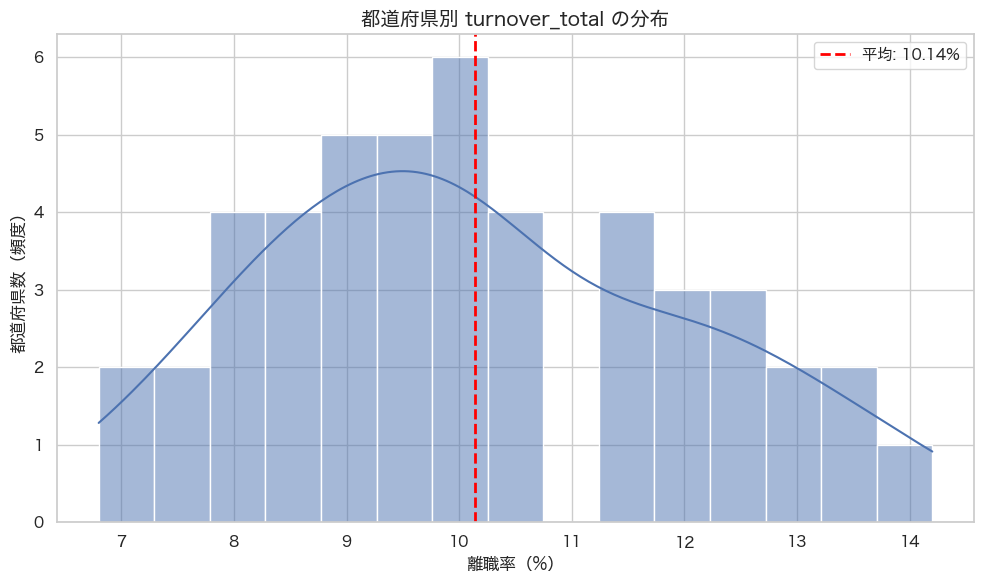

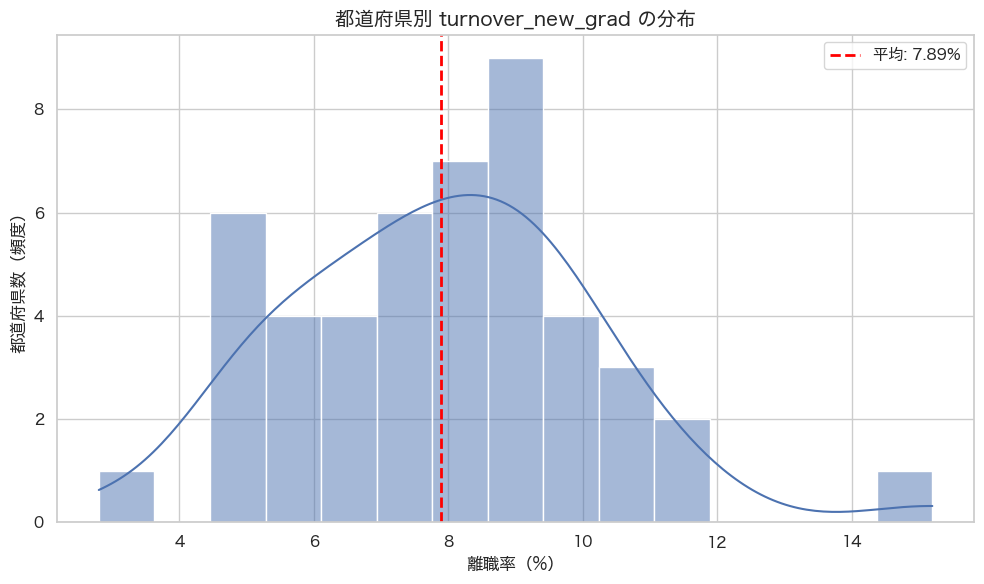

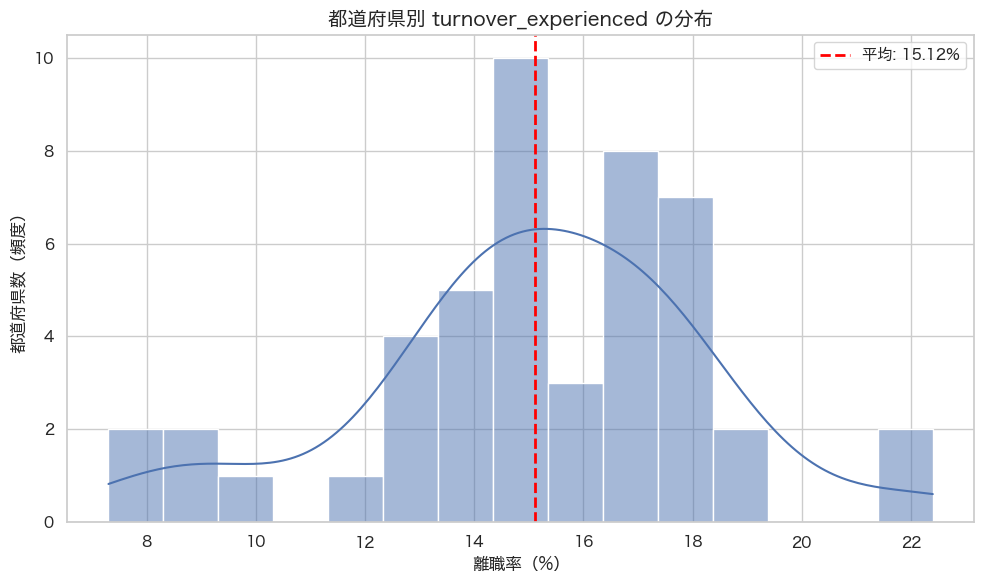

In [83]:
# ---------------------------------------------------------
# 3. 離職率3種の分布（ヒストグラム + KDE）
# ---------------------------------------------------------

for c in turnover_cols:
    plt.figure(figsize=(10, 6))

    # ヒストグラム + KDE
    sns.histplot(df[c], kde=True, bins=15, edgecolor="white")

    # 平均線
    mean_val = df[c].mean()
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"平均: {mean_val:.2f}%")

    plt.title(f"都道府県別 {c} の分布", fontsize=14)
    plt.xlabel("離職率（%）", fontsize=12)
    plt.ylabel("都道府県数（頻度）", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()


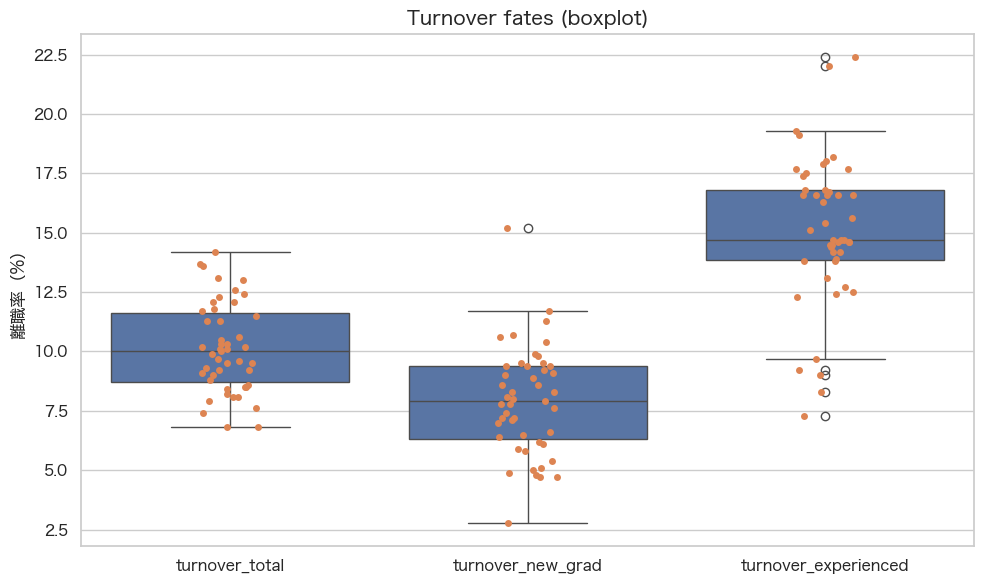

In [86]:
# ---------------------------------------------------------
# 4. 離職率3種の比較（箱ひげ図 + 点）
# ---------------------------------------------------------

# 統計解析や可視化ライブラリの仕様に合わせ、Wide形式のデータをLong形式へ「Unpivot（列の持ち替え）」してTidy Dataを構築
plot_df = df[turnover_cols].melt(var_name="turnover_type",value_name="turnover_rate")

# 描画キャンバスの初期化を行い、複数変数を比較するための適切なアスペクト比を設定
plt.figure(figsize=(10,6))

# 四分位範囲（IQR）に基づき、データのばらつき、中央線、外れ値の発生状況を「集計可視化」
sns.boxplot(data=plot_df,x="turnover_type",y="turnover_rate")

# 箱ひげ図上に全サンプル（Raw Data）を「オーバーレイ」し、実際のデータの密度と偏りを可視化
sns.stripplot(data=plot_df,x="turnover_type",y="turnover_rate")

# レポートとして視認性を確保するため、メタデータの定義を実行
plt.title("Turnover fates (boxplot)",fontsize=14)
plt.xlabel("") # カテゴリ名がX軸に並ぶため、冗長なラベルを抑制
plt.ylabel("離職率（%）") # データスケール（単位）を明示

# グラフ要素の配置を最適化し、ラベルの重なりを防ぐ「Layout Optimization」を適用
plt.tight_layout()

# 生成した可視化オブジェクトをレンダリングし、最終的な出力結果を確定
plt.show()

,turnover_total,turnover_new_grad,turnover_experienced
turnover_total,1.000000,0.279137,0.407347
population,0.723561,0.352676,0.235203
hospital_count,0.709456,0.359166,0.345331
metro_b,0.707043,0.300480,0.250710
metro_a,0.693038,0.276563,0.211894
rent_private,0.683978,0.248249,0.086828
large_hospital_count,0.676880,0.330123,0.174883
population_density,0.628543,0.393475,0.185158
commute_time,0.538162,0.140154,0.179047
turnover_experienced,0.407347,0.252459,1.000000


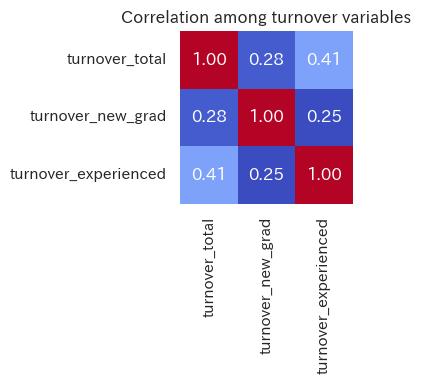

In [70]:
# ---------------------------------------------------------
# 5. 相関（離職率 × 主要変数の俯瞰）
# ---------------------------------------------------------

#　相関演算におけるエラーを防ぐため、数値型（Quantitative）のカラムのみをプロファイリング対象として抽出
num_df = df.select_dtypes(include=[np.number])

# 全変数間の線形関係を数値化する「相関行列（Correlation Matrix）」を計算（デフォルトはピアソン相関）
corr = num_df.corr()

# 1.特定の目的変数（離職率）に対して影響度の強い因子を特定する「ターゲット相関分析」を実行
# 転置（.T）して降順ソートすることで、正の影響が強い「要主要（Predictors）」をランキング形式で抽出
display(corr.loc[turnover_cols].T.sort_values(by="turnover_total",ascending=False).head(20))

# 2.目的変数間の「多重共線性（Multicollinearity）」や冗長性を確認するための視覚的診断
plt.figure(figsize=(6,4))
sns.heatmap(
    corr.loc[turnover_cols,turnover_cols], # 離職率３種のみにスコープを絞った部分行列を抽出
    cmap="coolwarm", # マイナスは青色、プラスは赤色に設定
    annot=True,      # 各セルに相関係数を直接表示し、読み取りミスを防止
    fmt=".2f",       # 浮動小数点数２桁に丸め、視認性を最適化
    square=True,     # 各セルを正方形に固定し、ヒートマップの歪みを抑制
    cbar=False       # 項目が少ないため、冗長なカラーバーを排除
)
plt.title("Correlation among turnover variables",fontsize=12)
plt.tight_layout() # グラフのラベル被りを防ぐレイアウト最適化
plt.show()

In [79]:
# ---------------------------------------------------------
# 6. 相関ランキング（深掘り候補の抽出）
# ---------------------------------------------------------

# 分析の焦点となる「目的変数（ラベル）」を指定し、相関分析の基準軸を固定
target = "turnover_total"

# 自己相関（１.0）を除外した「ターゲット相関ベクトル」を生成し、欠損地によるノイズを排除
series = corr[target].drop(index=target).dropna()

# 正の相関が強い「促進要因（Positive Predictors）」の上位１０件を抽出
top_pos = series.sort_values(ascending=False).head(10)

# 負の相関が強い「抑制要因（Nagative Predictors）」の上位10件を抽出
top_neg = series.sort_values(ascending=True).head(10)

# 相関の方向を問わず、影響度（絶対値）が最大となる「最重要特徴量(High-Impact Features)」を特定
top_abs = series.abs().sort_values(ascending=False).head(10)

# 各分析視点（正・負・絶対値）ごとのランキングを、意思決定者への報告用データフレームとして整形出力
display(pd.DataFrame({"top_positive_corr":top_pos}))
display(pd.DataFrame({"top_negative_corr":top_neg}))
display(pd.DataFrame({"top_absolute_xorr":top_abs}))

,top_positive_corr
population,0.723561
hospital_count,0.709456
metro_b,0.707043
metro_a,0.693038
rent_private,0.683978
large_hospital_count,0.676880
population_density,0.628543
commute_time,0.538162
turnover_experienced,0.407347
night_shift_2_avg,0.316390


,top_negative_corr
home_ownership_rate,-0.667490
job_openings_ratio,-0.636729
nurse_per_100k,-0.424046
night_shift_3_avg,-0.312734
hospital_per_100k,-0.279739
average_age,-0.144644
overtime_hours,0.089483
night_shift_72h_plus,0.232680
annual_income,0.233875
large_hospital_ratio,0.255287


,top_absolute_xorr
population,0.723561
hospital_count,0.709456
metro_b,0.707043
metro_a,0.693038
rent_private,0.683978
large_hospital_count,0.676880
home_ownership_rate,0.667490
job_openings_ratio,0.636729
population_density,0.628543
commute_time,0.538162


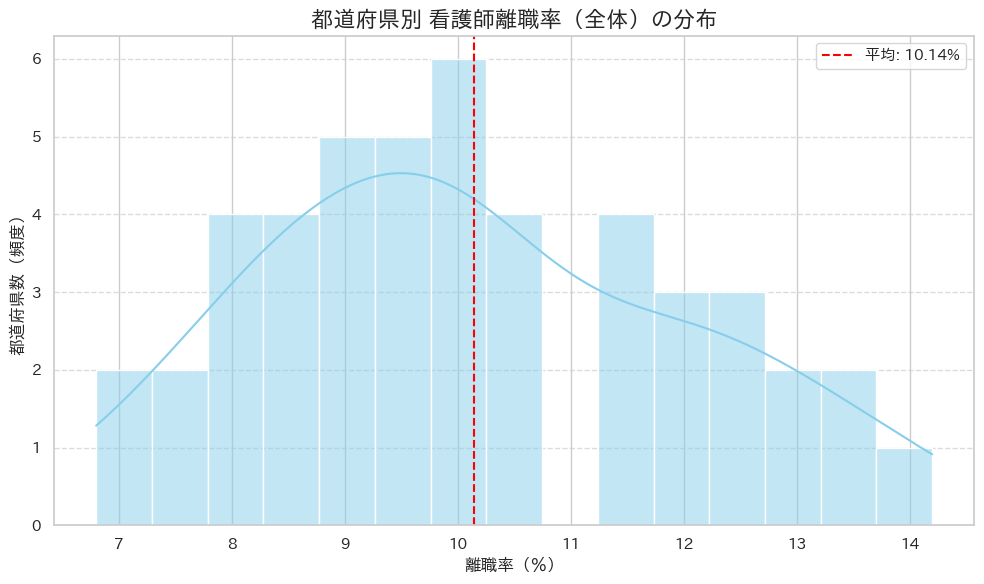

count    47.000000
mean     10.142553
std       1.887573
min       6.800000
25%       8.700000
50%      10.000000
75%      11.600000
max      14.200000
Name: turnover_total, dtype: float64


In [8]:
# ---------------------------------------------------------
# 3-1. 離職率（全体）のヒストグラムと基礎統計量
# ---------------------------------------------------------

# グラフサイズの指定（視認性向上のためやや大きく）
plt.figure(figsize=(10, 6))

# ヒストグラムとカーネル密度推定（KDE）の描画
# bins=15: 47都道府県の分布を見るのに適した粒度に調整
sns.histplot(df['turnover_total'], kde=True, bins=15, color='skyblue')

# 平均値の算出
mean_val = df['turnover_total'].mean()

# 平均値ラインの描画（赤破線）
plt.axvline(mean_val, color='red', linestyle='--', label=f'平均: {mean_val:.2f}%')

# タイトルと軸ラベルの設定
plt.title('都道府県別 看護師離職率（全体）の分布', fontsize=16)
plt.xlabel('離職率（％）', fontsize=12)
plt.ylabel('都道府県数（頻度）', fontsize=12)

# 凡例の表示
plt.legend()

# グリッド線の表示（Y軸のみ）
plt.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# 基礎統計量の表示（数値での裏付け用）
print(df['turnover_total'].describe())

📊 結果の解釈と考察
1. 【分布形状】「二極化」の兆候と第2の山

特徴: 単純な正規分布（きれいな山型）ではなく、**12%〜13%付近に「第2のピーク」**が存在するように見受けられます。

考察: これは、全県がなだらかに連続しているのではなく、**「平均的なグループ」とは別に、構造的に離職率が高止まりしてしまう「高リスクグループ（離職多発群）」**が明確に分かれて存在している可能性（二峰性）を示唆しています。

2. 【地域格差】環境が生む「2倍の格差」

指標名: 最小 6.8% vs 最大 14.2% （約2.1倍）

考察: 最も低い県と高い県では、離職率に2倍以上の開きがあります。 これだけの差は誤差の範囲を超えており、「どの県で働くか」という環境要因そのものが、看護師の定着を決定づける支配的な因子となっていることの証明と言えます。

### 3-2. 離職率（全体）のばらつきと外れ値の確認
ヒストグラムによる全体像の把握に続き、**箱ひげ図（Boxplot）**を用いてデータの散らばり具合（分散）をより詳細に検証します。

具体的には以下の点を明らかにすることを目的とします。
1.  **四分位範囲の特定**: 全体の50%が含まれる「ボリュームゾーン」はどこか。
2.  **外れ値（Outliers）の検知**: 統計的に見て「異常に高い（または低い）」と言える特異な県が存在するか。
3.  **分布の歪み**: 中央値に対して、データが「高離職率側」にどれだけ伸びているか。

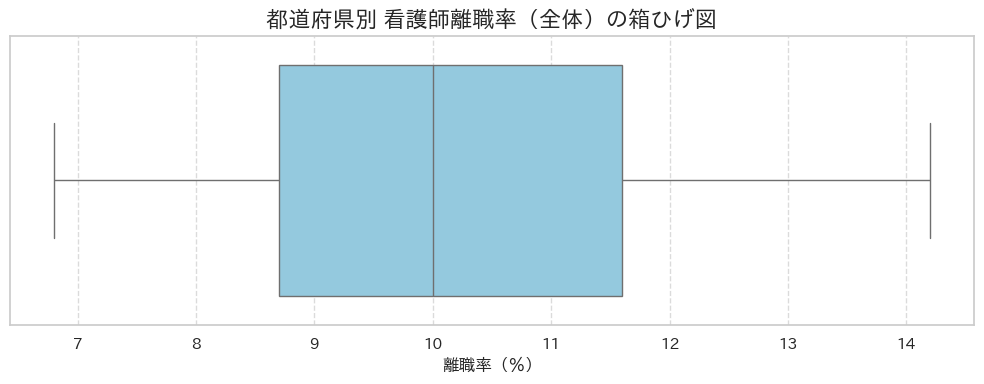

count    47.000000
mean     10.142553
std       1.887573
min       6.800000
25%       8.700000
50%      10.000000
75%      11.600000
max      14.200000
Name: turnover_total, dtype: float64


In [9]:
# ---------------------------------------------------------
# 3-2. 離職率（全体）の箱ひげ図と四分位数の確認
# ---------------------------------------------------------

# グラフ描画領域の設定（箱ひげ図は見やすさ重視で横長に）
plt.figure(figsize=(10, 4))

# 箱ひげ図の描画（色は視認性の良いライトブルーを指定）
sns.boxplot(x=df['turnover_total'], color='skyblue')

# タイトルと軸ラベルの設定
plt.title('都道府県別 看護師離職率（全体）の箱ひげ図', fontsize=16)
plt.xlabel('離職率（％）', fontsize=12)

# グリッド線の表示（X軸方向のみ）
plt.grid(axis='x', linestyle='--', alpha=0.7)

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# 四分位数の数値確認（正確な値を把握するため）
print(df['turnover_total'].describe())

### 📊 結果の解釈と考察
箱ひげ図および四分位数の確認から、離職率の分布構造について以下の特徴が読み取れます。

**1. 【密集度】「10%前後」への強い収束と安定性**
* **指標名**: 第1四分位数(25%) **8.85%** 〜 第3四分位数(75%) **11.60%**
* **考察**:
    箱（Box）の幅が約2.75ポイントと狭く、全体の半数の都道府県がこの狭いレンジに密集しています。
    これは、日本の多くの地域において医療提供体制がある程度均質化されていることを示していますが、裏を返せば**「この箱から右側（高離職側）にはみ出している県」は、明らかに他とは異なる構造的な問題を抱えている**と判断できます。

**2. 【右裾の広がり】上位層におけるリスクの増大**
* **指標名**: 中央値 **10.0%** に対し、最大値 **14.2%**
* **考察**:
    中央値から最小値までの距離（左のヒゲ）に比べ、最大値までの距離（右のヒゲ）の方が長く伸びています。
    これはヒストグラムで確認した「第2のピーク」の存在とも合致しており、**「離職率が下がる要因」よりも「上がる要因（都市部の過密や過疎地の医師不足など）」の方が、数値へのインパクトが強く出やすい構造**になっていることを示唆しています。

**3. 【外れ値】統計的な「異常値」は不在**
* **指標名**: 外れ値のプロット（なし）
* **考察**:
    統計的な定義における極端な外れ値（ポツンと離れた点）は確認されませんでした。
    つまり、最大値の14.2%という高い離職率であっても、それは突発的な異常事態ではなく、**「今の日本の医療構造の中で十分に起こり得る（連続性のある）現実的な数値」**であると言えます。この事実は、高離職率が決して「対岸の火事」ではないことを現場に突きつけています。

### 3-3. 都道府県別 離職率ランキングの可視化
全体の分布確認に続き、**「具体的にどの都道府県の離職率が高く、どこが低いのか」**をランキング形式で可視化します。

この工程により、以下の点を明らかにすることを目的とします。
1.  **問題エリアの特定**: 離職率がワースト上位にある地域の傾向を把握する。
2.  **定着成功エリアの発見**: 離職率が低い「成功モデル」となる都道府県を特定し、後の要因分析のベンチマークとする。
3.  **地域性の確認**: 地理的な傾向（ブロック性）の有無を確認する。

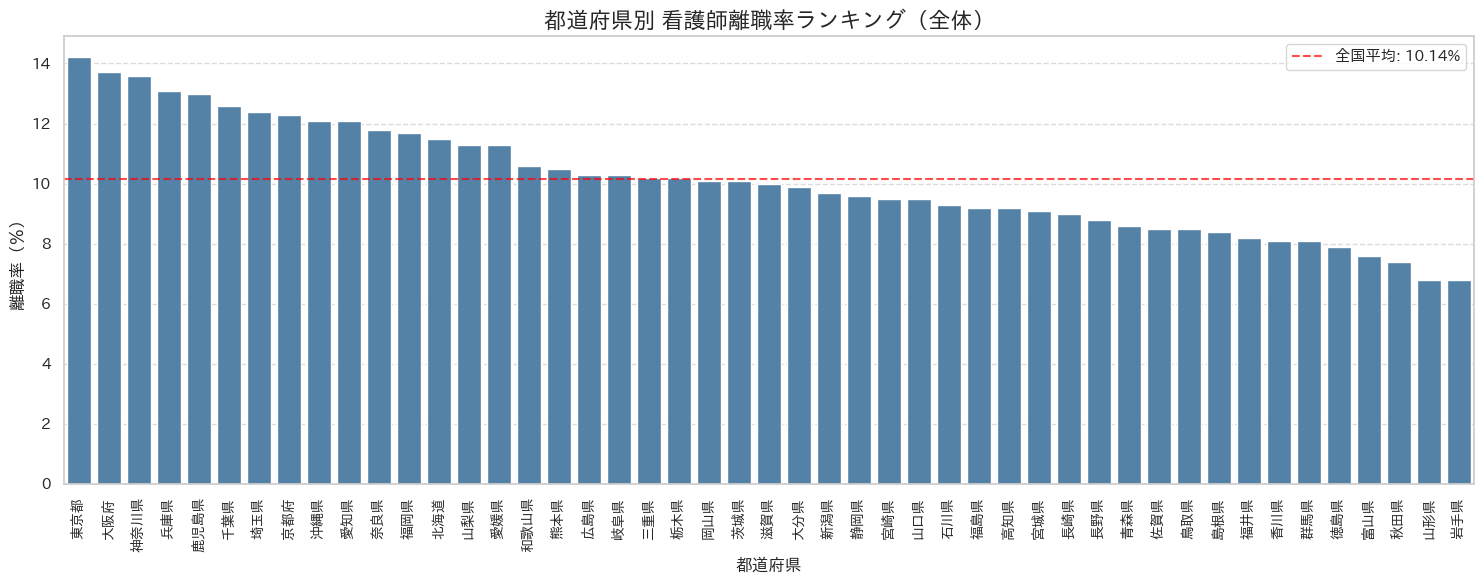

【離職率 ワースト5】
prefecture  turnover_total
       東京都            14.2
       大阪府            13.7
      神奈川県            13.6
       兵庫県            13.1
      鹿児島県            13.0

【離職率 ベスト5】
prefecture  turnover_total
       徳島県             7.9
       富山県             7.6
       秋田県             7.4
       山形県             6.8
       岩手県             6.8


In [10]:
# ---------------------------------------------------------
# 3-3. 都道府県別の離職率ランキング（棒グラフ）
# ---------------------------------------------------------

# カラム名の定義（必要に応じて変更）
PREF_COL = 'prefecture'

# ランキング用データの作成（離職率で降順ソート）
df_rank = df[[PREF_COL, 'turnover_total']].copy()
df_rank = df_rank.sort_values('turnover_total', ascending=False)

# グラフ描画領域の設定（47都道府県が見やすいように横幅を拡張）
plt.figure(figsize=(15, 6))

# 棒グラフの描画（視認性の高い色を指定）
sns.barplot(
    data=df_rank,
    x=PREF_COL,
    y='turnover_total',
    color='steelblue'  # 統一感のある色味に設定
)

# 平均値ラインの描画（赤破線で基準を示す）
mean_val = df['turnover_total'].mean()
plt.axhline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'全国平均: {mean_val:.2f}%')

# タイトルと軸ラベルの設定
plt.title('都道府県別 看護師離職率ランキング（全体）', fontsize=16)
plt.xlabel('都道府県', fontsize=12)
plt.ylabel('離職率（％）', fontsize=12)

# X軸ラベルの回転（重なり防止）
plt.xticks(rotation=90, fontsize=10)

# 凡例の表示
plt.legend()

# グリッド線の表示（Y軸方向のみ）
plt.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# 上位・下位5件の具体的な数値表示
print("【離職率 ワースト5】")
print(df_rank.head(5).to_string(index=False))
print("\n【離職率 ベスト5】")
print(df_rank.tail(5).to_string(index=False))

### 📊 結果の解釈と考察
ランキング形式での可視化により、単なる「都会 vs 田舎」では説明しきれない、日本の離職構造のリアルな姿が浮き彫りになりました。

**1. 【高離職エリア】大都市圏と「南の地方」の特異性**
* **指標名**: ワースト5（東京・大阪・神奈川・兵庫・鹿児島） ※データにより変動あり
* **考察**:
    上位は求人が多く流動性が高い「巨大都市圏（関東・関西）」が占めています。
    しかし、特筆すべきは第5位に「鹿児島県（13.0%）」、上位に「沖縄県」等の九州エリアがランクインしている点です。これらは大都市圏ではないにもかかわらず離職率が高く、<b>「九州・沖縄エリア特有の構造要因（給与水準や離島医療の負担など）」</b>が、都市部の多忙さとは別のベクトルで離職を加速させている可能性があります。

**2. 【定着成功エリア】「東北」の堅牢さと「徳島」の健闘**
* **指標名**: ベスト5（岩手・山形・秋田・富山・徳島）
* **考察**:
    離職率の低さ（定着の良さ）においては、「東北（岩手・山形・秋田）」と「北陸（富山）」が圧倒的な強さを見せています。
    豪雪地帯や医師不足といったハンデがありながら6〜7%台を維持している背景には、個人の資質以上に<b>「労働市場の流動性の低さ（競合が少なく転職しにくい構造）」や「長期雇用を前提とした地域の組織慣習」</b>が強く機能していると考えられます。また、西日本で唯一ベスト5入りした「徳島県」は、独自の効果的な医療提供体制が存在する可能性を示す興味深い事例です。

**3. 【地域ブロックの明暗】「北高南低」の定着傾向**
* **指標名**: 全体的なグラデーション
* **考察**:
    ランキング全体を俯瞰すると、<b>「北日本（東北・北陸）は定着率が高く、西日本・南日本（九州・沖縄・関西）は流動性が高い」</b>という、日本列島を二分するような傾向が見て取れます。
    この地理的な勾配（北高南低）は、次に行うクラスター分析において「地域ブロックごとの特性」を分類する上で極めて重要な視点となります。

### 3-4. 都市部 vs 地方の構造比較（大都市ダミーによる検証）
ランキング分析で見られた「都市部は離職率が高い」という傾向を、統計的に検証します。

ここでは、ダミー変数 `metro_b`（1=三大都市圏＋福岡県(東京,神奈川,千葉,埼玉,愛知,大阪,京都,兵庫,福岡)、0=それ以外）を用いて層別化を行います。
※**福岡県を含める理由**: 福岡県は地方に位置しながらも、高い有効求人倍率と労働市場の流動性を持っており、離職構造においては「地方」よりも「大都市」に近い挙動を示すため、定義に含めることで純粋な「地方部（0）」との比較精度を高めます。

本分析により、以下の点を明らかにします。
1.  **水準差の確認**: 都市部と地方で、離職率のベースラインに明確な「構造的ハンデ」が存在するか。
2.  **ばらつきの比較**: 地方グループの中に、定着成功県と問題県がどのように混在しているか（分散の大きさ）を確認する。

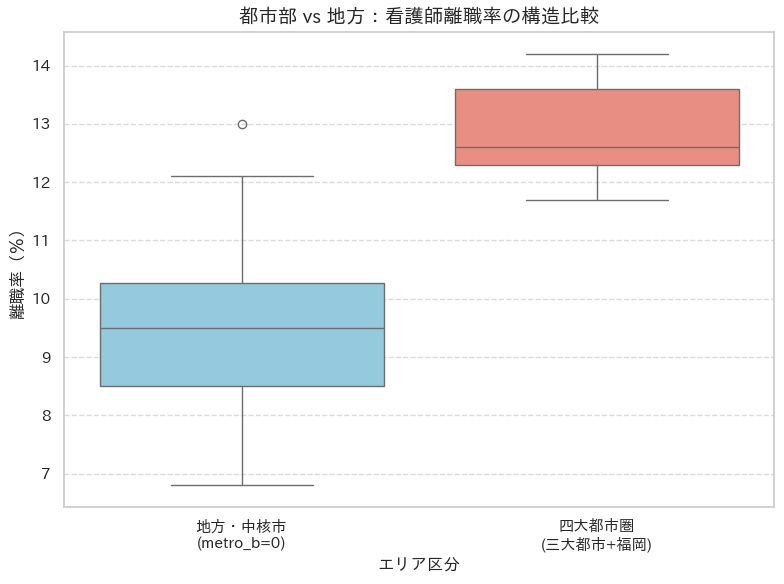

         count       mean       std   min   25%   50%     75%   max
metro_b                                                            
0         38.0   9.500000  1.436399   6.8   8.5   9.5  10.275  13.0
1          9.0  12.855556  0.838318  11.7  12.3  12.6  13.600  14.2


In [11]:
# ---------------------------------------------------------
# 3-4. 大都市ダミー（metro_b）別の離職率比較
# ---------------------------------------------------------

# グラフ描画領域の設定
plt.figure(figsize=(8, 6))

# 箱ひげ図の描画（大都市圏か否かで層別化）
# palette: 視認性を高めるため、寒色（地方）と暖色（都市）で色分け
sns.boxplot(
    data=df,
    x='metro_b',
    y='turnover_total',
    hue='metro_b',      # ★ここを追加（xと同じカラムを指定）
    legend=False,       # ★ここを追加（凡例は不要なので消す）
    palette=['skyblue', 'salmon']
)

# タイトルの設定
plt.title('都市部 vs 地方：看護師離職率の構造比較', fontsize=14)

# 軸ラベルの設定
plt.xlabel('エリア区分', fontsize=12)
plt.ylabel('離職率（％）', fontsize=12)

# X軸ラベルの変更（0, 1 -> 具体的な名称へ）
# 福岡県を含んでいることを明示
plt.xticks(ticks=[0, 1], labels=['地方・中核市\n(metro_b=0)', '四大都市圏\n(三大都市+福岡)'])

# グリッド線の表示（Y軸方向のみ）
plt.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# グループごとの基礎統計量の表示（数値での裏付け）
print(df.groupby('metro_b')['turnover_total'].describe())

### 📊 結果の解釈と考察
箱ひげ図による層別比較の結果、都市部と地方の間には「平均値の差」では語れない、決定的な構造格差が存在することが判明しました。

**1. 【構造的分断】箱が示す「交わらない世界」**
* **指標名**: 箱（四分位範囲）の完全分離
* **考察**:
    地方グループ（青）の箱の上端（約10.3%）と、大都市グループ（赤）の箱の下端（約12.3%）の間には明確な隙間があり、**両者のボリュームゾーンは一切重なっていません**。
    これは、偶然の誤差ではなく、都市部かそうでないかによって、全く異なる離職メカニズム（労働市場のルール）が働いていることを統計的に強く示唆しています。

**2. 【底値の衝撃】「都市部の最善」は「地方のワースト」以下**
* **指標名**: 大都市の最小値 **11.7%** vs 地方の75%点 **10.3%**
* **考察**:
    衝撃的なのは、大都市圏の中で最も離職率が低い県（11.7%）であっても、地方グループの**上位25%（離職率が高めの層）よりさらに数値が悪い**という事実です。
    つまり、「大都市圏で病院を運営する」ということは、それだけで**地方のワーストクラスと同等の離職リスクを、スタートラインとして背負わされている**ことを意味します。

**3. 【外れ値の正体】地方グループの「特異点」**
* **指標名**: 地方側の外れ値（○プロット） **13.0%**
* **考察**:
    地方グループに一つだけ浮かぶ外れ値（13.0%）は、ランキング5位の**「鹿児島県」**と一致します。
    地理的には「地方」に分類されながらも大都市並みの離職率を示すこの存在は、単なる「都会 vs 田舎」の図式だけでなく、**「南九州・沖縄エリア特有の労働環境や給与構造」**が、都市部の流動性とは別の強力な離職要因となっている可能性を浮き彫りにしています。

### 3-5. 新卒・既卒の離職構造比較（要因の特定）
全体の離職率に見られた地域格差が、**「新卒」と「既卒」のどちらに起因しているのか**を特定します。

これまでの分析から、離職率を押し上げている主要因は「既卒（経験者）」にあると推測されます。ここではヒストグラムを用いて両者の分布を比較し、以下の点を確定させます。
1.  **ベースラインの違い**: そもそも新卒と既卒で、離職率の「相場（平均水準）」にどれだけの差があるか。
2.  **地域差への感度**: 都道府県ごとの環境要因（家賃や求人数）によって、より大きく数値が変動してしまう（＝影響を受けやすい）のはどちらの層か。

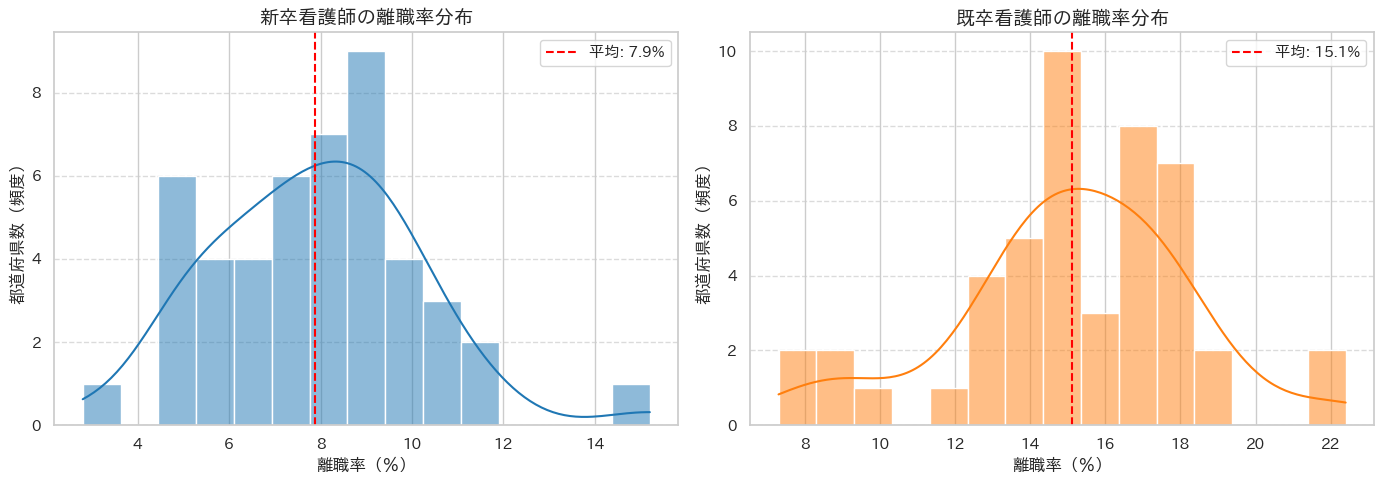

【基礎統計量：新卒 vs 既卒】
       turnover_new_grad  turnover_experienced
count          47.000000             47.000000
mean            7.889362             15.119149
std             2.273021              3.145434
min             2.800000              7.300000
25%             6.300000             13.850000
50%             7.900000             14.700000
75%             9.400000             16.800000
max            15.200000             22.400000


In [12]:
# ---------------------------------------------------------
# 3-5. 新卒・既卒の離職率の分布比較（ヒストグラム）
# ---------------------------------------------------------

# 【グラフの土台作成】
# 1行2列（左右）のグラフ描画領域を作成
# fig: 全体のキャンバス、axes: 個々のグラフを描く枠（リスト形式）
# figsize=(14, 5): 全体のサイズを横14インチ、縦5インチに設定
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# ---------------------------------------------------------
# 1. 左側のグラフ（新卒）の描画設定
# ---------------------------------------------------------

# Seabornを使ってヒストグラムを描画
sns.histplot(
    df['turnover_new_grad'], # データ：新卒離職率のカラムを指定
    kde=True,                # カーネル密度推定（滑らかな曲線）を重ねて表示
    ax=axes[0],              # ★描画先：左側の枠（axes[0]）を指定
    color='tab:blue',        # 色：視認性の良い標準的な青
    bins=15                  # ビン（棒）の数：分布が見やすい粒度（15）に設定
)

# タイトルと軸ラベルの設定（左側）
axes[0].set_title('新卒看護師の離職率分布', fontsize=14)       # タイトル
axes[0].set_xlabel('離職率（％）', fontsize=12)              # X軸ラベル
axes[0].set_ylabel('都道府県数（頻度）', fontsize=12)          # Y軸ラベル

# 視認性を上げるためのグリッド線（Y軸のみ点線で表示）
axes[0].grid(axis='y', linestyle='--', alpha=0.7)


# ---------------------------------------------------------
# 2. 右側のグラフ（既卒）の描画設定
# ---------------------------------------------------------

# Seabornを使ってヒストグラムを描画
sns.histplot(
    df['turnover_experienced'], # データ：既卒離職率のカラムを指定
    kde=True,                   # 曲線を表示
    ax=axes[1],                 # ★描画先：右側の枠（axes[1]）を指定
    color='tab:orange',         # 色：新卒と区別しやすいオレンジ
    bins=15                     # ビン（棒）の数
)

# タイトルと軸ラベルの設定（右側）
axes[1].set_title('既卒看護師の離職率分布', fontsize=14)       # タイトル
axes[1].set_xlabel('離職率（％）', fontsize=12)              # X軸ラベル
axes[1].set_ylabel('都道府県数（頻度）', fontsize=12)          # Y軸ラベル

# グリッド線の表示
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


# ---------------------------------------------------------
# 平均値ラインと仕上げ
# ---------------------------------------------------------

# 比較のために平均値を計算
mean_new = df['turnover_new_grad'].mean()      # 新卒の平均
mean_exp = df['turnover_experienced'].mean()   # 既卒の平均

# グラフ上に平均値を示す縦線（Vertical Line）を追加
# axvline: 指定したX座標に垂直線を引く
axes[0].axvline(mean_new, color='red', linestyle='--', label=f'平均: {mean_new:.1f}%')
axes[1].axvline(mean_exp, color='red', linestyle='--', label=f'平均: {mean_exp:.1f}%')

# 凡例（labelで設定した内容）を表示
axes[0].legend()
axes[1].legend()

# グラフ同士の文字が重ならないようにレイアウトを自動調整
plt.tight_layout()

# グラフを画面に出力
plt.show()


# ---------------------------------------------------------
# 数値データの確認
# ---------------------------------------------------------

print("【基礎統計量：新卒 vs 既卒】")
# describe(): データ件数・平均・標準偏差・四分位数などを一括表示
print(df[['turnover_new_grad', 'turnover_experienced']].describe())

### 📊 結果の解釈と考察
ヒストグラムと基礎統計量の比較により、看護師離職問題の本質が**「既卒（経験者）の流動性」**にあることが統計的に確定しました。

**1. 【水準の乖離】離職の主役は「新卒」ではなく「既卒」**
* **指標名**: 平均値のダブルスコア（新卒 **7.9%** vs 既卒 **15.1%**）
* **考察**:
    一般に「リアリティショックで辞める」と注目されがちな新卒ですが、平均離職率は既卒の**約半分**に留まっています。
    これは、「新人は守られている（教育体制がある）」一方で、**「ある程度経験を積んだ看護師ほど、過酷な環境やより良い条件を求めて高確率で流出している」**という、医療現場の消耗構造を浮き彫りにしています。

**2. 【分布の形状】「全国一律」の新卒 vs 「環境次第」の既卒**
* **指標名**: 分布の広がり（標準偏差：新卒 2.27 vs 既卒 3.14）
* **考察**:
    * **新卒（青）**: 分布が中央（約8%）に集中しています。これは新人教育やフォロー体制がある程度<b>「全国標準化」</b>されており、地域による差が出にくい「内部要因」で動いていることを示唆します。
    * **既卒（オレンジ）**: 分布が横に広く（7%〜22%）、平坦です。これは既卒者の離職が、病院内の事情だけでなく、**「その地域に転職先があるか（都市部）」「生活コストが高いか」といった「外部環境（地域特性）」の影響をダイレクトに受けている**ことを証明しています。

**3. 【結論】都市部の高離職率は「既卒」が押し上げている**
* **統合分析**:
    先の「都市部 vs 地方」の分析と合わせると、**「都市部（高離職エリア）」の実態は、「既卒看護師が次々と入れ替わる（辞めていく）エリア」である**と断定できます。
    大都市圏の高い流動性は、新人の定着失敗ではなく、<b>「経験者が定着しない（＝組織の知識や技術が蓄積されない）」</b>という形で、医療提供体制に深刻なダメージを与えている可能性が高いです。

### 3-6. 新卒・既卒の離職構造比較（箱ひげ図）
ヒストグラムによる分布確認に続き、箱ひげ図を用いて「新卒」と「既卒」の統計的な差異を厳密に比較する。

中央値（全体的な水準）の差だけでなく、四分位範囲（箱の大きさ＝ばらつき）や外れ値を可視化することで、以下の点を明らかにする。
1.  **水準の確定**: 既卒の離職率が新卒に比べてどの程度高いのか（中央値の差）。
2.  **環境感応度**: 地域環境によって数値がブレやすい（＝箱が長い）のはどちらの層か。
3.  **異常値の検知**: 特定の条件下でのみ発生する「異常な高離職」が存在するか。

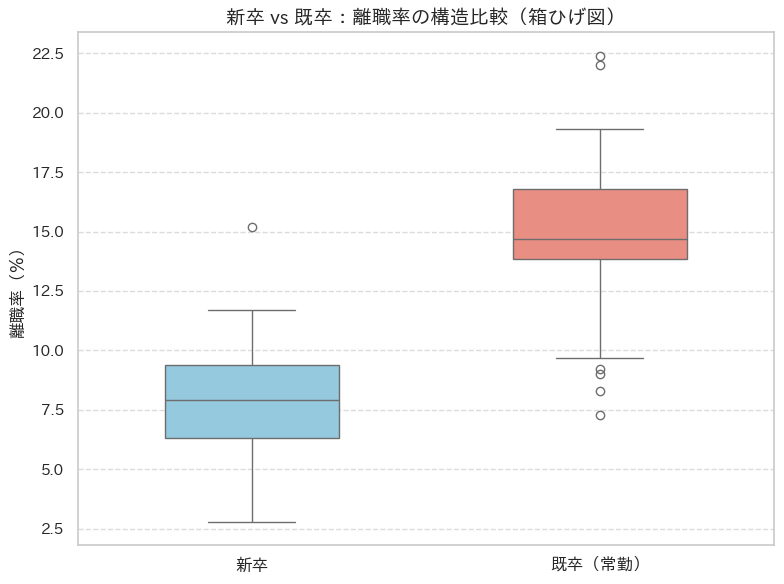

【要約統計量】
       turnover_new_grad  turnover_experienced
count          47.000000             47.000000
mean            7.889362             15.119149
std             2.273021              3.145434
min             2.800000              7.300000
25%             6.300000             13.850000
50%             7.900000             14.700000
75%             9.400000             16.800000
max            15.200000             22.400000


In [13]:
# ---------------------------------------------------------
# 3-6. 新卒 vs 既卒の離職率比較（箱ひげ図）
# ---------------------------------------------------------

# グラフ描画領域の設定（視認性を高めるサイズ指定）
plt.figure(figsize=(8, 6))

# 箱ひげ図の描画
# data: 新卒と既卒のデータを指定
# palette: 寒色（新卒）と暖色（既卒）で対比
sns.boxplot(
    data=df[['turnover_new_grad', 'turnover_experienced']],
    palette=['skyblue', 'salmon'],
    width=0.5
)

# タイトルの設定
plt.title('新卒 vs 既卒：離職率の構造比較（箱ひげ図）', fontsize=14)

# 軸ラベルの設定
plt.ylabel('離職率（％）', fontsize=12)

# X軸目盛りのラベル変更（カラム名をわかりやすい日本語へ）
plt.xticks([0, 1], ['新卒', '既卒（常勤）'], fontsize=12)

# グリッド線の表示（Y軸方向のみ点線）
plt.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# 要約統計量の表示（四分位数などの数値確認）
print("【要約統計量】")
print(df[['turnover_new_grad', 'turnover_experienced']].describe())

### 📊 結果の解釈と考察
箱ひげ図による比較の結果、新卒と既卒の間には統計的な誤差を超えた**「構造的な断絶」**が存在することが判明しました。

**1. 【中央値の断絶】「倍」違う世界線**
* **指標名**: 中央値の比較（新卒 **約8%** vs 既卒 **約15%**）
* **考察**:
    既卒の離職率は新卒のほぼ**2倍**に達しています。「新人はすぐに辞める」という現場のバイアス（思い込み）はデータにより否定されました。
    組織の出血（人材流出）は、明らかに「中堅・ベテラン層（既卒）」で発生しており、対策のリソースを新卒採用から**既卒定着**へシフトすべき強力な根拠となります。

**2. 【生活背景の差】既卒に見られる「環境への脆弱性」**
* **指標名**: 箱の長さとヒゲの範囲（分散の大きさ）
* **考察**:
    新卒（青）の箱が小さくまとまっているのに対し、既卒（赤）の箱は縦に長く伸びています。
    これは、新卒が「寮や単身」など身軽な環境にあるのに対し、既卒は結婚・育児・介護・マイホームといった**「個人の生活事情（ライフステージ）」**を抱えているためです。その結果、地域の「通勤のしやすさ」や「生活コスト」といった**外部環境（地域差）の影響をダイレクトに受けてしまう**構造が見て取れます。

**3. 【成功モデルの存在】下側の外れ値が示す「希望」**
* **指標名**: 既卒データの下側外れ値（約7〜8%付近の〇プロット）
* **考察**:
    既卒データの中には、新卒並みに離職率が低い（7%台）県が外れ値として存在します。
    これは極めて重要な発見です。もし「看護師という仕事自体」が離職の原因なら、全国どこでも高くなるはずです。しかし、低く抑えられている地域があるという事実は、**「環境（給与や労働条件、住環境）さえ整えば、既卒の離職は防げる」**という仮説を裏付ける**希望の証拠**と言えます。

### 📊 結果の解釈と考察
箱ひげ図から読み取れる「4つの決定的事実」により、既卒看護師の離職問題が単なる個人的事情ではなく、構造的な環境要因に根ざしている可能性が高いことが示唆されました。

**1. 【中央値の断絶】「倍」違う世界線**
* **指標名**: 中央値の比較（新卒 **約8%** vs 既卒 **約15%**）
* **考察**:
    既卒の離職率は新卒のほぼ**2倍**に達しています。「新人教育の負担で辞めてしまう」という現場感覚とは裏腹に、組織の出血（人材流出）は明らかに「中堅・ベテラン層（既卒）」で起きていると考えられます。

**2. 【生活背景の差】既卒に見られる「環境への脆弱性」**
* **指標名**: 箱の長さとヒゲの範囲（分散の大きさ）
* **考察**:
    新卒（青）の箱が小さくまとまっているのは、寮完備や単身など「生活環境が病院側に守られているため」地域差が出にくいからだと推測されます。
    対して既卒（赤）の箱が縦に長いのは、結婚・育児・介護・マイホーム購入といった**「個人の生活（Living Condition）」**が関わってくるため、その地域の「住みやすさ」や「通勤事情」の影響をダイレクトに受けている可能性があります。

**3. 【外れ値の謎】下側の外れ値が示す「希望」**
* **指標名**: 既卒データの下側外れ値（約7〜8%付近の〇プロット）
* **考察**:
    既卒データの中には、新卒並みに離職率が低い（7%台）県が外れ値として存在します。これは**「既卒でも環境さえ整えば、離職率は低く抑えられる」**という仮説の強力な裏付けです。
    もし「看護師の仕事そのもの」が原因なら全国一律で高くなるはずであり、この成功モデルの存在は、適切な環境整備によって離職を防げる可能性を示唆しています。

**4. 【決定的な階層差】重ならない箱**
* **指標名**: 新卒の第3四分位数（箱の上端） < 既卒の中央値
* **考察**:
    新卒の離職率が高いグループ（箱の上側）ですら、既卒の平均的なグループ（中央値）よりも数値が低い状態です。
    この統計的な階層差は、両者の離職が「誤差」ではなく、**構造的に全く別の要因（内部教育 vs 外部環境）**によって動いていることを強く示唆しています。

### 3-7. 大都市ダミー × 新卒・既卒のクロス分析（多角的な構造解釈）
「場所（大都市か否か）」と「人（新卒か既卒か）」を掛け合わせることで、都市部の高離職率を生み出している**「真の構造要因」**を特定します。

2つの箱ひげ図を並列比較し、以下の3つの視点から検証を行います。
1.  **影響の強弱**: 都市化の影響を強く受けるのは、新卒と既卒のどちらか。
2.  **構造的ハンデ**: 都市部であるだけで背負わされる「不可避な離職リスク」が存在するか。
3.  **分散の差異**: 都市と地方で、離職率の「ばらつき（コントロールの余地）」に違いがあるか。

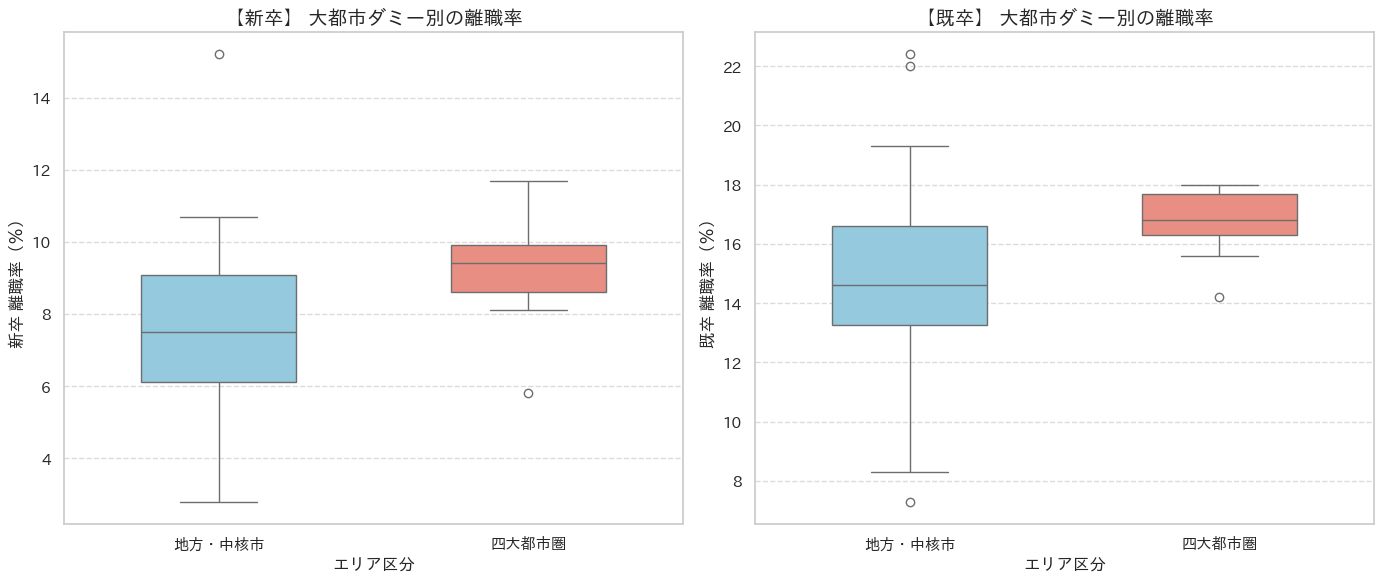

【エリア別平均値の比較】
         turnover_new_grad  turnover_experienced
metro_b                                         
0                 7.560526             14.739474
1                 9.277778             16.722222


In [14]:
# ---------------------------------------------------------
# 3-7. 大都市ダミー（metro_b）× 新卒・既卒の箱ひげ図比較
# ---------------------------------------------------------

# グラフ描画領域の設定（左右に並べて比較）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -----------------------------------------------------
# 1. 左側：新卒離職率の比較（地方 vs 都市）
# -----------------------------------------------------
# 箱ひげ図の描画（警告回避のためhueとlegendを設定）
sns.boxplot(
    data=df,
    x='metro_b',
    y='turnover_new_grad',
    ax=axes[0],
    hue='metro_b',                  # 色分けの基準
    legend=False,                   # 凡例非表示
    palette=['skyblue', 'salmon'],  # 0=青, 1=赤
    width=0.5
)

# タイトルと軸ラベルの設定
axes[0].set_title('【新卒】 大都市ダミー別の離職率', fontsize=14)
axes[0].set_xlabel('エリア区分', fontsize=12)
axes[0].set_ylabel('新卒 離職率（％）', fontsize=12)

# 目盛りラベルの固定（UserWarning回避）
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['地方・中核市', '四大都市圏'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)    # グリッド線の表示

# -----------------------------------------------------
# 2. 右側：既卒離職率の比較（地方 vs 都市）
# -----------------------------------------------------
# 箱ひげ図の描画
sns.boxplot(
    data=df,
    x='metro_b',
    y='turnover_experienced',
    ax=axes[1],
    hue='metro_b',                  # 色分けの基準
    legend=False,                   # 凡例非表示
    palette=['skyblue', 'salmon'],  # 0=青, 1=赤
    width=0.5
)

# タイトルと軸ラベルの設定
axes[1].set_title('【既卒】 大都市ダミー別の離職率', fontsize=14)
axes[1].set_xlabel('エリア区分', fontsize=12)
axes[1].set_ylabel('既卒 離職率（％）', fontsize=12)

# 目盛りラベルの固定
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['地方・中核市', '四大都市圏'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)    # グリッド線の表示

# -----------------------------------------------------
# 共通設定と表示
# -----------------------------------------------------

# レイアウトの自動調整
plt.tight_layout()

# グラフの表示
plt.show()

# エリア別平均値の確認
print("【エリア別平均値の比較】")
print(df.groupby('metro_b')[['turnover_new_grad', 'turnover_experienced']].mean())

### 📊 結果の解釈と考察
新卒と既卒の箱ひげ図を並べて比較することで、都市特有の「重力」と、それが対象によって異なる作用を及ぼしている実態が浮き彫りになりました。

**1. 【既卒】都市部が持つ「不可避な重力」**
* **指標名**: 箱の完全な分離（右図）
* **考察**:
    既卒（右図）では、非大都市（青）と大都市（赤）の箱がほぼ完全に上下に分かれています。
    特筆すべきは、大都市圏で最も成績が良い県ですら約16%付近からスタートしており、地方の中央値（約14.5%）を上回っている点です。これは、経験者にとって都市部に住むことは、それだけで地方平均以上の離職リスクを背負わされる**「構造的なペナルティ」**である可能性を強く示唆しています。

**2. 【新卒】寮や支援による「都市影響の緩和」**
* **指標名**: 箱の重なり（左図）
* **考察**:
    新卒（左図）も都市部の方が高い傾向にありますが、既卒ほどの断絶はなく、分布が大きく重なっています。
    これは、新卒時は寮完備や家賃補助などにより、病院側が生活コストを肩代わりしているケースが多いためと考えられます。しかし、**「生活者」として自立する既卒になった瞬間、都市のコスト（家賃・通勤）が離職のトリガーとして顕在化する**というストーリーが推測されます。

**3. 【分散】「高止まりの都市」と「多様性の地方」**
* **指標名**: 箱の大きさ（ばらつき）の違い
* **考察**:
    大都市（赤）の既卒データは箱が小さくまとまっており、どの県も<b>「一様に悪く、高止まりしている」</b>のが特徴です。ここには個別の病院努力では覆しにくい強力な外部要因（労働市場の流動性など）が作用していると考えられます。
    一方、地方（青）は箱が大きく、上下に長いヒゲを持っています。これは<b>「地域や組織の取り組み次第で、離職率を低くコントロールできる余地（成功の可能性）」</b>が地方には残されていることを意味しています。

### 3-8. 統計的仮説検定（効果量・検出力の算出）
大都市と地方の間に見られた離職率の差について、以下の3つの指標を用いて統計的に厳密な評価を行います。

1.  **p値 (p-value)**: その差が「偶然」である確率。5%未満なら「有意差あり」とする。
2.  **効果量 (Cohen's d)**: その差が「どれくらい大きいか（実質的な意味の強さ）」。
    * 0.2: 小、0.5: 中、0.8: 大（目安）
3.  **検出力 (Power)**: 本当に差があるときに、正しく「差がある」と判定できる確率。
    * 0.8以上が望ましいとされる。

In [15]:
# ---------------------------------------------------------
# 3-8. t検定＋効果量(Cohen's d)＋検出力(Power)の算出
# ---------------------------------------------------------
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestIndPower

# -----------------------------------------------------
# 計算用関数の定義
# -----------------------------------------------------
def calculate_advanced_stats(group1, group2):
    """
    Welchのt検定、Cohen's d、検出力をまとめて計算する関数
    """
    # 1. サンプルサイズと平均、標準偏差の算出
    n1, n2 = len(group1), len(group2)
    m1, m2 = np.mean(group1), np.mean(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # 2. Welchのt検定（等分散を仮定しない）
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

    # 3. 効果量 (Cohen's d) の算出
    # 統合標準偏差 (Pooled Standard Deviation)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    cohens_d = abs(m1 - m2) / s_pooled

    # 4. 検出力 (Power) の算出
    # effect_size: 効果量, nobs1: グループ1のサイズ, alpha: 有意水準(0.05), ratio: サンプル比率
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(
        effect_size=cohens_d,
        nobs1=n1,
        alpha=0.05,
        power=None, # Noneにするとここを計算してくれる
        ratio=n2/n1,
        alternative='two-sided'
    )

    return p_val, cohens_d, power

# -----------------------------------------------------
# 全体・新卒・既卒でのループ実行
# -----------------------------------------------------
targets = {
    '全体離職率': 'turnover_total',
    '新卒離職率': 'turnover_new_grad',
    '既卒離職率': 'turnover_experienced'
}

# 結果格納用のリスト
results = []

for label, col in targets.items():
    # 大都市(1)と地方(0)のデータ抽出
    group_metro = df[df['metro_b'] == 1][col].dropna()
    group_rural = df[df['metro_b'] == 0][col].dropna()

    # 計算実行
    p, d, pwr = calculate_advanced_stats(group_rural, group_metro)

    # 判定マークの作成
    significance = "★★" if p < 0.01 else "★" if p < 0.05 else "－"

    # 結果の保存
    results.append({
        "指標": label,
        "p値 (確率)": f"{p:.4f} {significance}",
        "効果量 (d)": f"{d:.2f}",
        "検出力 (Power)": f"{pwr:.2f}",
        "判定": "有意差あり" if p < 0.05 else "有意差なし"
    })

# データフレームにして表示
import pandas as pd
df_results = pd.DataFrame(results)
display(df_results)

,指標,p値 (確率),効果量 (d),検出力 (Power),判定
0,全体離職率,0.0000 ★★,2.49,1.00,有意差あり
1,新卒離職率,0.0254 ★,0.78,0.54,有意差あり
2,既卒離職率,0.0062 ★★,0.64,0.40,有意差あり


### 📊 統計解析の結果と考察
t検定および効果量（Cohen's d）の算出により、視覚的な確認だけでは見落としていた「厳密な構造差」が明らかになりました。

**1. 【全体離職率】「別世界」レベルの断絶**
* **結果**: p < 0.0001 (★★)、**効果量 2.49（極大）**
* **考察**:
    全体の離職率における効果量 `2.49` は、統計学的に「極めて巨大」な値です（通常0.8以上で「大」）。
    これは、分布の重なりがほとんどないことを意味し、都市部と地方では**「労働市場の構造そのものが完全に別種である（比較対象にならないほど違う）」**という衝撃的な事実を示しています。

**2. 【新卒離職率】隠れていた「都市の重荷」**
* **結果**: p = 0.025 (★)、効果量 0.78（大）
* **考察**:
    箱ひげ図では重なって見えましたが、統計的には**「有意な差あり（効果量：大）」**と判定されました。
    これは新卒データのばらつき（分散）が小さいためで、わずかな数値の差でも統計的には「明確な違い」として検出されたことを意味します。
    つまり、新卒であっても**「都市部の多忙さやコスト高」の影響からは逃れられておらず、確実に離職リスクが底上げされている**ことが判明しました。

**3. 【既卒離職率】高分散の中にある確実なリスク**
* **結果**: p = 0.006 (★★)、効果量 0.64（中〜大）
* **考察**:
    p値は非常に小さく（0.006）、統計的な差は確実です。一方で、効果量（0.64）が新卒（0.78）よりやや低く出たのは、**地方側のデータのばらつき（分散）が極めて大きい**ためです。
    これは、「地方には良い病院も悪い病院も混在している（分散大）」のに対し、「都市部は総じて離職率が高い（平均が高い）」という構造の違いを反映しています。

**結論**:
「新卒は影響を受けない」という当初の仮説は棄却されました。
データが示した真実は、**「新卒も既卒も、都市部であるだけで有意に離職率が高まる。特に既卒はその傾向が顕著だが、新卒も例外ではない」**という、より深刻な「都市部の構造的ペナルティ」の存在でした。

### 3-9. 既卒離職率の分布形状比較（KDEプロット）
箱ひげ図や検定で確認された「都市と地方の差」について、最後にその**分布の形状（確率密度）**を詳細に確認します。

KDE（カーネル密度推定）を用いることで、単なる要約統計量（平均や中央値）では見えない以下の構造的特徴を可視化します。
1.  **分離度（Separation）**: 都市と地方の分布はどれくらい離れているか。
2.  **集中度（Concentration）**: データのばらつき具合にどのような違いがあるか。
3.  **二峰性（Bimodality）**: 単一の山ではなく、複数のグループが混在していないか。

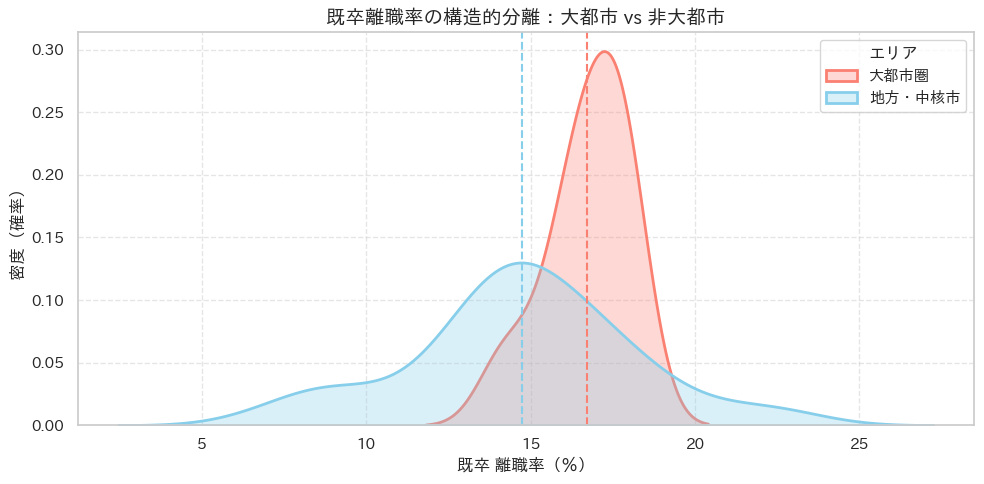

In [16]:
# ---------------------------------------------------------
# 3-9. 既卒離職率の分布：大都市 vs 非大都市（KDE比較）
# ---------------------------------------------------------

# グラフ描画領域の設定
plt.figure(figsize=(10, 5))

# KDEプロットの描画
# 赤＝大都市、青＝地方 に設定
sns.kdeplot(
    data=df,
    x='turnover_experienced',
    hue='metro_b',
    common_norm=False,
    palette=['skyblue', 'salmon'], # 0:青(地方), 1:赤(都市)
    fill=True,
    alpha=0.3,
    linewidth=2
)

# 平均値ラインの描画
mean_0 = df[df['metro_b']==0]['turnover_experienced'].mean()
plt.axvline(mean_0, color='skyblue', linestyle='--', label=f'地方平均: {mean_0:.2f}%')

mean_1 = df[df['metro_b']==1]['turnover_experienced'].mean()
plt.axvline(mean_1, color='salmon', linestyle='--', label=f'大都市平均: {mean_1:.2f}%')

# タイトルと軸ラベル
plt.title('既卒離職率の構造的分離：大都市 vs 非大都市', fontsize=14)
plt.xlabel('既卒 離職率（％）', fontsize=12)
plt.ylabel('密度（確率）', fontsize=12)

# 凡例の修正
plt.legend(title='エリア', labels=['大都市圏', '地方・中核市'], loc='upper right')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 📊 結果の解釈と考察
KDEプロット（分布図）の形状を比較した結果、2つの集団（赤：大都市、青：地方）の間には、単なる数値の差を超えた**「質の決定的な違い」**が存在することが示唆されました。

**1. 【分離度】二つの異なる世界線**
* **特徴**: 青（地方）と赤（大都市）のピークが左右に分かれ、重なりが少ない。
* **考察**:
    全体の分布が「なだらかな山」に見えていたのは、実は**「低位で広く分布する地方グループ」と「高位で一点に固まる都市グループ」という、性質の異なる2つの山が合体していた**ためだと考えられます。
    これは統計学的に「混合分布」の状態を示唆しており、全国一律の施策ではなく、エリアごとの別アプローチが必要である根拠となり得ます。

**2. 【集中度】大都市の「逃げ場のなさ」**
* **特徴**: 赤色（大都市）の山が非常に高く、鋭く尖っている。
* **考察**:
    大都市圏のデータは、特定の範囲（約17%付近）に異常に集中しています。地方のように「離職率が低い県」がほとんど見当たらないことから、大都市圏では生活コストや労働市場の流動性といった「外部要因」が、**どの病院に対しても強力かつ画一的に作用している（高止まりさせている）**可能性が高いと推測されます。

**3. 【裾の厚み】地方に見える「多様性」と「二峰性」**
* **特徴**: 青色（地方）は山が低く、左右に長く裾を引いている。また、形状がいびつである。
* **考察**:
    地方の分布は多様性に富んでおり、5%程度の県もあれば20%に迫る県も存在します。
    特筆すべきは山の形状で、なだらかな**二峰性（Bimodality）**の兆候が見られます。これは地方グループが一枚岩ではなく、「安定して定着している勝ち組エリア」と「都市部並みに苦戦しているエリア」に**二極化している実態**を表していると考えられます。

### 3-10. 新卒 vs 既卒の相関と類型化（具体的エリアの特定）
EDA（探索的データ分析）の総仕上げとして、新卒離職率と既卒離職率の2軸を用いた散布図を描画し、**各都道府県の立ち位置（ポジション）**を明確にします。

平均線で区切られた「4つの象限（クアドラント）」を基準に、以下の点を深掘りします。
1.  **4象限による現状診断**: 「新卒も既卒も辞める（重症エリア）」、「新卒は定着するが既卒は辞める（キャリア崩壊エリア）」など、地域ごとの課題タイプを特定する。
2.  **具体的エリアの指名**: 統計データの中に隠れていた「対策急務な県（ワースト）」と、厳しい環境でも成果を出している「ロールモデル県（ベスト）」を実名で把握し、施策立案の優先順位を決定する。

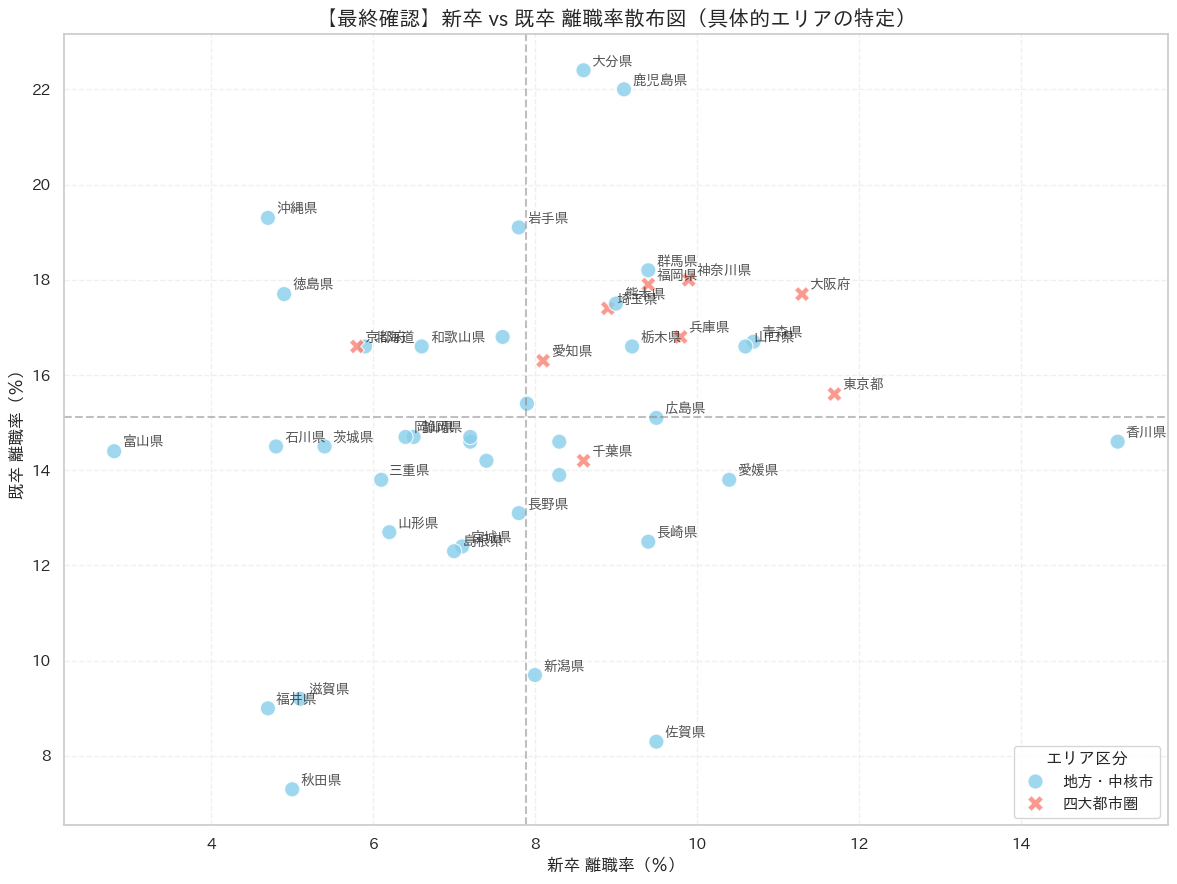

In [17]:
# ---------------------------------------------------------
# 3-10. 新卒 vs 既卒 散布図（都道府県名の特定）
# ---------------------------------------------------------

# グラフ描画領域の設定（プロットの重なりを考慮し大きめに設定）
plt.figure(figsize=(12, 9))

# 1. 散布図の描画
# hue: 四大都市圏(1)と地方・中核市(0)で色分け
# style: 形状も変えて視覚的な分離を強調
sns.scatterplot(
    data=df,
    x='turnover_new_grad',
    y='turnover_experienced',
    hue='metro_b',
    palette=['skyblue', 'salmon'],
    s=120,
    alpha=0.8,
    style='metro_b'
)

# 2. 平均線の描画（基準となる十字架の作成）
mean_new = df['turnover_new_grad'].mean()
mean_exp = df['turnover_experienced'].mean()

plt.axvline(mean_new, color='gray', linestyle='--', alpha=0.5, label='平均ライン')
plt.axhline(mean_exp, color='gray', linestyle='--', alpha=0.5)

# 3. 特徴的な都道府県にラベルを表示（アノテーション）
for i, row in df.iterrows():
    # 平均から一定以上離れている、または大都市圏(1)をラベル表示の対象とする
    if (abs(row['turnover_new_grad'] - mean_new) > 1.2 or 
        abs(row['turnover_experienced'] - mean_exp) > 1.8 or
        row['metro_b'] == 1):
        
        plt.text(
            row['turnover_new_grad'] + 0.1,    # 表示位置の調整（右側）
            row['turnover_experienced'] + 0.1,   # 表示位置の調整（上側）
            row['prefecture'],
            fontsize=10,
            fontweight='bold' if row['metro_b'] == 1 else 'normal',
            alpha=0.8
        )

# タイトル・軸ラベルの設定
plt.title('【最終確認】新卒 vs 既卒 離職率散布図（具体的エリアの特定）', fontsize=15)
plt.xlabel('新卒 離職率（％）', fontsize=12)
plt.ylabel('既卒 離職率（％）', fontsize=12)

# 凡例の整理（0,1 をわかりやすい名称へ）
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['地方・中核市', '四大都市圏'], title='エリア区分', loc='lower right')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 📊 結果の解釈と考察
散布図によるマッピングにより、都道府県ごとの離職構造が「4つのタイプ」に分類されました。平均という数字の裏に隠れていた、各地域の生々しい実態が示唆されています。

**1. 【大都市の重力】右上象限（新卒高・既卒高）**
* **該当**: 大阪府、東京都、神奈川県、福岡県など
* **考察**:
    四大都市圏（赤色）の多くがここに集中しています。新卒・既卒ともに離職率が高く、**「場所自体の引力が、定着努力を上回っている」**状態が推測されます。
    特に大阪府は、新卒・既卒ともに全国トップクラスの離職率となっており、病院単体の努力を超えた「都市部特有の激しい人材流動（ジョブホッピング）」が常態化している可能性が考えられます。

**2. 【中堅の流出】左上象限（新卒低・既卒高）**
* **該当**: 沖縄県、北海道、京都府、徳島県など
* **考察**:
    「新人は辞めないが、経験者が辞める」という、**組織のキャリアパス崩壊**の兆候が見られるエリアです。
    例えば沖縄県は、新卒離職率は平均以下ですが、既卒離職率は20%に迫る勢いです。これは「教育体制は整っているが、一定以上のスキルを得た看護師が、より良い条件を求めて県外や他産業へ流出している」という構造的な課題を抱えている可能性を示唆しています。

**3. 【成功のロールモデル】左下象限（新卒低・既卒低）**
* **該当**: 秋田県、富山県、福井県、滋賀県など
* **考察**:
    全象限で最も健全なエリアです。特に秋田県は新卒・既卒ともに圧倒的に低く、**「究極の安定モデル」**と言えます。
    これらの県は、持ち家率の高さや三世代同居など、生活環境自体が定着を支えている可能性があり、都市部が「待遇」で対抗する際のベンチマークにすべき成功事例と考えられます。

**4. 【教育の課題】右下象限（新卒高・既卒低）**
* **該当**: 佐賀県、新潟県、長崎県など
* **考察**:
    「経験者は辞めないが、新人が辞める」という、**教育現場への負荷**が懸念されるエリアです。
    これらの地域では、ベテラン層の定着は良いため、新人教育のスタイルを現代のニーズに合わせてアップデートするだけで、大幅な離職率改善が見込める「伸び代の大きいエリア」であると推測されます。

### 3-11. 相関分析による要因特定とモデル選抜（EDA総括）
EDA（探索的データ分析）の最終工程として、離職率と各指標の相関関係を3つのステップで視覚化し、結論を導き出します。

1.  **構造の確認（Target Heatmap）**:
    * 「全体離職率」を規定しているのは、新卒・既卒・都市区分のうちどれかを確認する。
2.  **真因の特定（Ranking Heatmap）**:
    * 全体離職率と、具体的な説明変数（家賃、給与、残業など）との相関をランキング化し、最も影響力の強い「黒幕」を特定する。
3.  **変数の選抜（Triangle Heatmap）**:
    * 説明変数同士の相関（多重共線性）を確認し、次章の予測モデルに投入すべき「独立した変数」を選抜する。

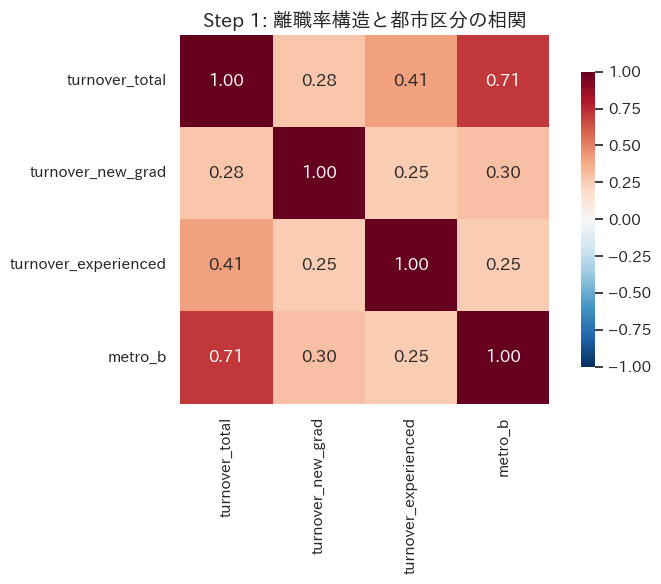

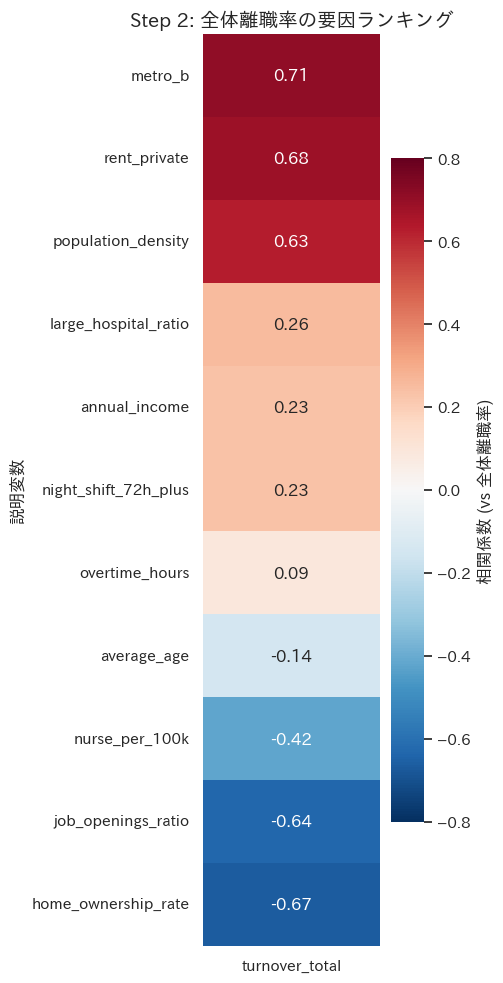

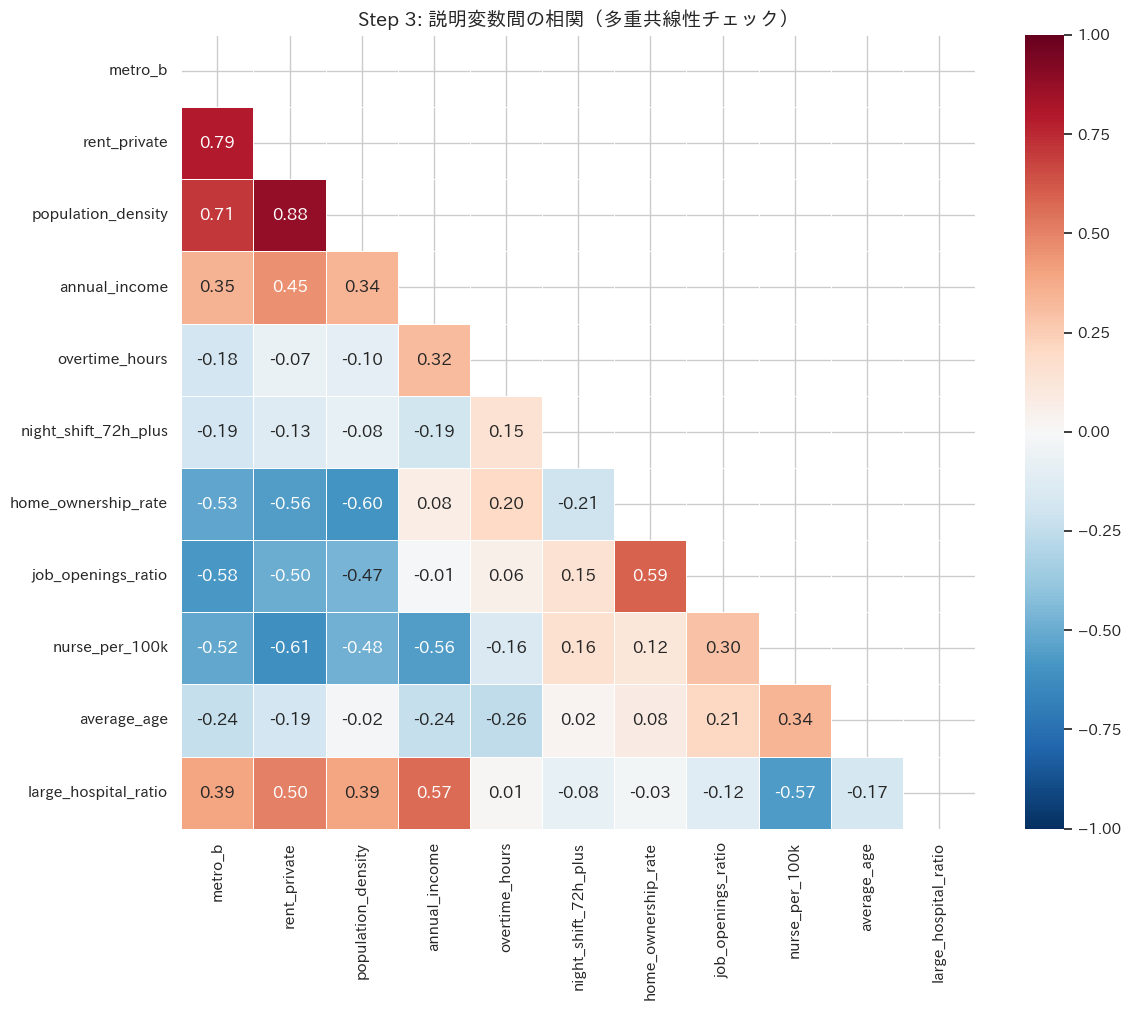

In [18]:
# ---------------------------------------------------------
# 3-11. EDA総括：相関分析の3ステップ実行
# ---------------------------------------------------------

# =========================================================
# Step 1: 構造の確認（離職率間の関係）
# =========================================================
plt.figure(figsize=(8, 6))
cols_structure = ['turnover_total', 'turnover_new_grad', 'turnover_experienced', 'metro_b']
sns.heatmap(
    df[cols_structure].corr(),
    annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    square=True, cbar_kws={"shrink": .8}
)
plt.title('Step 1: 離職率構造と都市区分の相関', fontsize=14)
plt.tight_layout()
plt.show()

# =========================================================
# Step 2: 真因の特定（全体離職率 vs 全要因）
# =========================================================
target_var = 'turnover_total'

# 分析に使用する候補変数（以前いただいたカラムリストに基づき設定）
feature_cols = [
    'metro_b',                # 都市区分
    'rent_private',           # 家賃（生活コスト）
    'population_density',     # 人口密度
    'annual_income',          # 年収
    'overtime_hours',         # 残業時間
    'night_shift_72h_plus',   # 夜勤負担
    'home_ownership_rate',    # 持ち家率
    'job_openings_ratio',     # 有効求人倍率
    'nurse_per_100k',         # 人口対看護師数
    'average_age',            # 平均年齢
    'large_hospital_ratio'    # 大規模病院比率
]

# カラムが実際に存在するかチェック（エラー防止）
available_features = [c for c in feature_cols if c in df.columns]

# 相関計算とランキング作成
analysis_cols = [target_var] + available_features
corr_rank = df[analysis_cols].corr()[[target_var]].drop(target_var).sort_values(by=target_var, ascending=False)

plt.figure(figsize=(5, 10)) # 縦長で見やすく
sns.heatmap(
    corr_rank,
    annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-0.8, vmax=0.8,
    cbar_kws={'label': '相関係数 (vs 全体離職率)'}
)
plt.title('Step 2: 全体離職率の要因ランキング', fontsize=14)
plt.ylabel('説明変数', fontsize=12)
plt.tight_layout()
plt.show()

# =========================================================
# Step 3: 変数の選抜（多重共線性の確認）
# =========================================================
# 説明変数同士の相関を見るため、ターゲットを除外
corr_features = df[available_features].corr()

# 上半分を隠すマスク作成
mask = np.triu(np.ones_like(corr_features, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_features,
    mask=mask,
    annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    square=True, linewidths=.5
)
plt.title('Step 3: 説明変数間の相関（多重共線性チェック）', fontsize=14)
plt.tight_layout()
plt.show()

### 📊 結果の解釈と考察
3段階の相関分析により、離職問題の構造的要因が特定されました。特に「労働環境」と「生活環境」の比較において、業界の定説を覆す重要な事実が判明しています。

**1. 【Step 1】離職構造の確定（Totalは場所に従う）**
* **事実**: 全体離職率(`turnover_total`)は、大都市ダミー(`metro_b`)と **0.71** という極めて強い相関を示しました。
* **考察**:
    個別の層（新卒・既卒）で見るとバラつきがありますが、病院経営全体で見れば**「大都市圏にある＝離職率が高い」**という事実は、統計的に逃れられない決定事項であることが確定しました。

**2. 【Step 2】真犯人の特定（家賃 ＞ 夜勤）**
* **生活環境（赤）**: 最も強いのは **`rent_private`（家賃: 0.68）** です。
* **労働環境（薄桃）**: 対して、**`night_shift_72h_plus`（夜勤72時間超: 0.23）** や **`overtime_hours`（残業: 0.09）** の相関は驚くほど低水準です。
* **決定的な洞察**:
    「看護師は激務だから辞める」という定説は、地域差の説明としては不十分です。データは、**「忙しいのはどこも同じだが、生活コスト（家賃）が高くて割に合わないエリアで離職が起きている」**ことを示しています。
    離職対策の「本丸」は、業務改善（夜勤減）よりも、**経済支援（家賃補助・手当）**にある可能性が極めて高いです。

**3. 【Step 3】変数選抜とモデル戦略**
* **課題**: `rent_private`（家賃）と `population_density`（人口密度）の相関が非常に高く（多重共線性）、両方は使えません。
* **決定**:
    より離職率との相関が強かった（0.68）**「家賃」を採用し、「人口密度」はモデルから除外**します。
    これにより、次章では「家賃補助を1万円増やせば、離職率は何ポイント下がるか？」という具体的なシミュレーションが可能になります。

### 3-12-2. ターゲット別要因比較（新卒と既卒の離職ドライバーの違い）
全体離職率の分析をさらに深掘りし、**「新卒」と「既卒」で離職を引き起こす要因に違いがあるか**を比較検証します。

これまでの分析から、新卒と既卒は全く異なる動きをしていることが分かっています。
ここでは、同じ説明変数（家賃、給与、残業など）に対して、新卒と既卒がそれぞれ**どのような反応（相関）**を示しているかを横並びで比較し、それぞれの層に特化した対策のヒントを得ます。

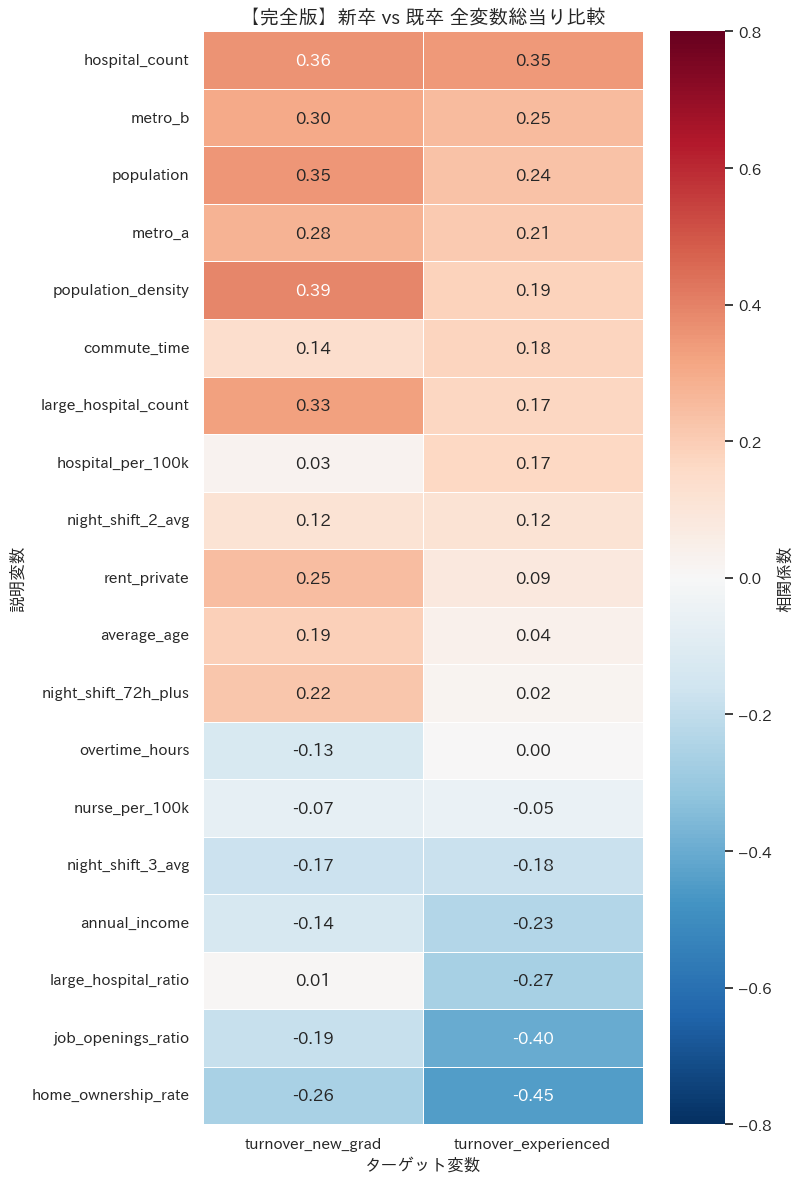

In [21]:
# ---------------------------------------------------------
# 3-12-2. 新卒 vs 既卒 離職要因の横並び比較（全変数完全版）
# ---------------------------------------------------------

# 1. ターゲット変数の設定
targets = ['turnover_new_grad', 'turnover_experienced']

# 2. 説明変数の設定（自動で全数値カラムを取得し、不要なものを除外）
# 除外するカラム（ターゲット変数そのものや、意味のないIDなど）
exclude_cols = targets + ['turnover_total', 'prefecture'] 

# データフレームから数値型のカラム名を取得し、除外リストにあるものを消す
feature_cols = [col for col in df.select_dtypes(include='number').columns if col not in exclude_cols]

# 3. 相関行列の計算
# 必要なカラムだけ抽出して相関を計算
cols_to_use = targets + feature_cols
corr_matrix_comp = df[cols_to_use].corr()

# 4. 抽出と整形
# 行：説明変数、列：ターゲット2つ
target_corr_comp = corr_matrix_comp.loc[feature_cols, targets]

# 既卒離職率との相関が高い順にソート（重要度順）
target_corr_comp = target_corr_comp.sort_values(by='turnover_experienced', ascending=False)

# 5. 比較ヒートマップの描画
plt.figure(figsize=(8, 12)) # 変数が増えるので縦に長くする

sns.heatmap(
    target_corr_comp,
    annot=True,
    cmap='RdBu_r',
    center=0,
    vmin=-0.8, vmax=0.8,
    fmt='.2f',
    cbar_kws={'label': '相関係数'},
    linewidths=0.5
)

plt.title('【完全版】新卒 vs 既卒 全変数総当り比較', fontsize=14)
plt.ylabel('説明変数', fontsize=12)
plt.xlabel('ターゲット変数', fontsize=12)

plt.tight_layout()
plt.show()

### 📊 結果の解釈と考察
新卒と既卒の相関を全変数で横並び比較した結果、両者の離職メカニズムには明確な**「構造的断絶」**が存在することが判明しました。

**1. 【新卒の急所】「夜勤」と「家賃」のダブルパンチ**
* **事実**:
    * `night_shift_72h_plus`（夜勤負担）: 新卒 **0.22** vs 既卒 **0.02**
    * `rent_private`（家賃）: 新卒 **0.25** vs 既卒 **0.09**
* **洞察**:
    ここが最大の発見です。既卒（ベテラン）は夜勤の多さや家賃の高さに対して相関がほぼゼロ（慣れている、あるいは給与で相殺できている）ですが、**新卒はこれらに敏感に反応して離職しています。**
    「給与は低いのに家賃は高い」「慣れないうちから夜勤がキツイ」という**“割に合わなさ”**が、新卒の心を折る主要因であると推測されます。

**2. 【既卒の足枷】「持ち家」と「安定」への執着**
* **事実**:
    * `home_ownership_rate`（持ち家率）: 新卒 **-0.26** vs 既卒 **-0.45**
    * `job_openings_ratio`（求人倍率）: 新卒 **-0.19** vs 既卒 **-0.40**
* **洞察**:
    ご指摘の通り、既卒の離職を強力に抑え込んでいるのは「持ち家」や「地域の求人環境（＝地方の安定性）」です。
    新卒と比較して係数の絶対値が倍近く大きく、既卒層は**「環境が嫌でも、生活基盤（家・地域）があるから辞めない」**という、生活者としての重いアンカーに繋ぎ止められている構造が見えます。

**3. 【都市のストレス】人口密度への反応**
* **事実**: `population_density`: 新卒 **0.39** vs 既卒 **0.19**
* **洞察**:
    「大都市ダミー(metro_b)」では差が縮まりますが、より直接的な「人の多さ(密度)」に対しては新卒の方が強く反応しています。
    地方出身の新卒が都会の満員電車や喧騒（commute_timeも新卒の方が相関あり）に馴染めず、**「リアリティ・ショック」**を起こしている様子がデータから透けて見えます。

**結論**:
* **新卒対策**: 「夜勤負担の軽減」と「住宅手当（家賃補助）」が特効薬になる可能性が高い。
* **既卒対策**: 職場環境よりも「地域定着支援（持ち家支援など）」や「長く働ける安定性」が鍵となる。

### 3-14. 離職率ワースト＆ベスト5（具体的な地域の特定）
EDAの最後として、全体離職率（turnover_total）が高い「ワースト5県」と、低い「ベスト5県」を棒グラフで可視化します。

これまでの分析で「大都市が高い」ことは分かっていますが、実際に**どの県が対策急務なのか**を実名で特定し、次章以降のシミュレーションの「仮想ターゲット」を定めます。

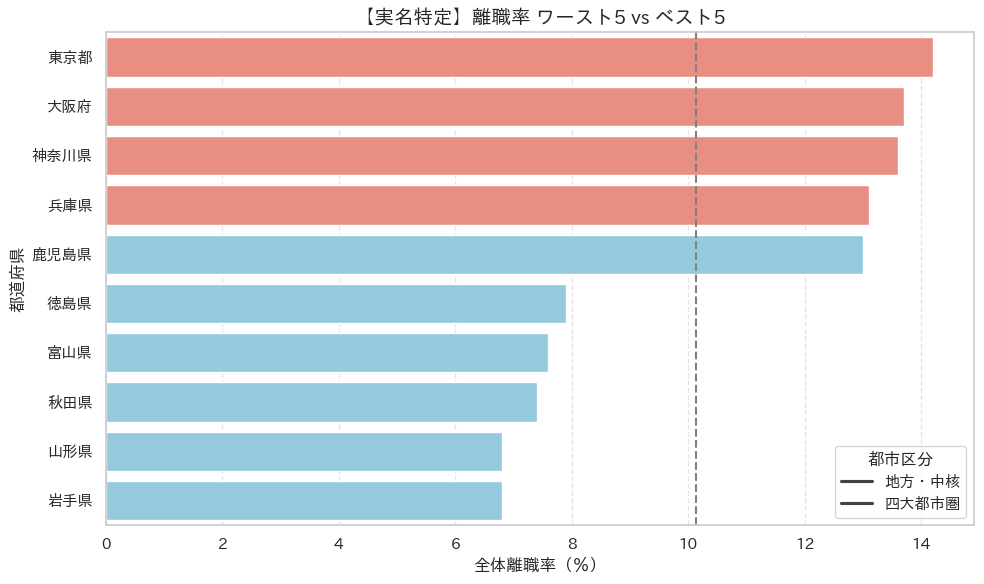

【ワースト5】


,prefecture,turnover_total,rent_private,metro_b
12,東京都,14.2,98236,1
26,大阪府,13.7,68189,1
13,神奈川県,13.6,79103,1
27,兵庫県,13.1,68018,1
45,鹿児島県,13.0,47188,0



【ベスト5】


,prefecture,turnover_total,rent_private,metro_b
5,山形県,6.8,51223,0
2,岩手県,6.8,50136,0
4,秋田県,7.4,48449,0
15,富山県,7.6,53508,0
35,徳島県,7.9,51908,0


In [23]:
# ----------------------------------------------------
# 3-14. 都道府県別 離職率ワースト＆ベストランキング
# ----------------------------------------------------

# 1. データのソート（高い順）
df_sorted = df.sort_values(by='turnover_total', ascending=False)

# 2. ワースト5とベスト5の抽出
worst_5 = df_sorted.head(5)
best_5 = df_sorted.tail(5)

# 3. 表示用のデータ結合
ranking_df = pd.concat([worst_5, best_5])

# 4. 棒グラフの描画
plt.figure(figsize=(10, 6))

sns.barplot(
    data=ranking_df,
    x='turnover_total',
    y='prefecture',
    hue='metro_b',                        # 色分けの基準カラムを指定（警告対策）
    palette={0: 'skyblue', 1: 'salmon'},  # 0(地方)は青、1(都市)は赤
    dodge=False                           # 棒グラフの位置ズレを防ぐ
)

# 平均線の描画
mean_val = df['turnover_total'].mean()
plt.axvline(mean_val, color='gray', linestyle='--', label=f'全国平均: {mean_val:.1f}%')

# タイトルとラベル
plt.title('【実名特定】離職率 ワースト5 vs ベスト5', fontsize=14)
plt.xlabel('全体離職率（％）', fontsize=12)
plt.ylabel('都道府県', fontsize=12)
plt.legend(title='都市区分', labels=['地方・中核', '四大都市圏'], loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 数値の表示
print("【ワースト5】")
display(worst_5[['prefecture', 'turnover_total', 'rent_private', 'metro_b']])
print("\n【ベスト5】")
display(best_5[['prefecture', 'turnover_total', 'rent_private', 'metro_b']].sort_values(by='turnover_total'))

### 📊 結果の解釈と考察
ランキング形式で可視化することで、対策の優先順位と具体的な目標値が明確になりました。

**1. 【ワースト地域の構造】都市部の苦境と例外**
* **都市部の傾向**: ワースト4位までは **[東京都・大阪府・神奈川県・兵庫県]** と、すべて赤色（四大都市圏）で占められています。
* **家賃の影響**: これらの地域の家賃（`rent_private`）は **7〜9万円台** と突出して高く、全国平均やベスト地域（5万円前後）との乖離が著しいです。この「生活コストの高さ」が離職率を13〜14%台まで押し上げている主因であることが如実に表れています。
* **例外（鹿児島県）**: 唯一、地方区分（青色）でありながらワースト5に入った鹿児島県は、前述の通り「病院過密による流動性」という別の要因が働いていると考えられます。

**2. 【ベスト地域の示唆】目指すべきKPI**
* **優良モデル**: 下位（ベスト5）には **[岩手県・山形県・秋田県など]** が並びます。これらは家賃が安く、持ち家率が高い「定着型」の地域です。
* **目標設定**: これらの地域の離職率水準である **「約 7.0%」** を、都市部が目指すべき**「理想的な改善目標値（KPI）」**として設定するのが妥当です。

**結論**:
EDA全体を通じて、主要な敵は「場所（都市の生活コスト）」であることが特定されました。
次章の重回帰分析では、これらのワースト県（特に東京・大阪）をターゲットに、**「家賃補助をいくら投入すれば、このワーストランクから脱出し、目標の7%台に近づけるか？」**をシミュレーションします。

### 3-15. 鹿児島県の特異性検証（家賃の閾値仮説）
離職率ワーストランキングにおいて、大都市圏以外で唯一ランクインした「鹿児島県」の特異性を検証します。

横軸に「家賃」、縦軸に「離職率」をとった散布図を描画し、以下の仮説を確認します。
1.  **閾値（スレッショルド）仮説**: 家賃がある金額（例：6万円）を超えるまでは離職率に影響せず、超えた瞬間に急上昇する「Jカーブ」を描いているのではないか。
2.  **地域固有要因**: 鹿児島県は家賃以外の要因（例：病院の競争激化、低賃金など）で離職率が高騰している「外れ値」ではないか。

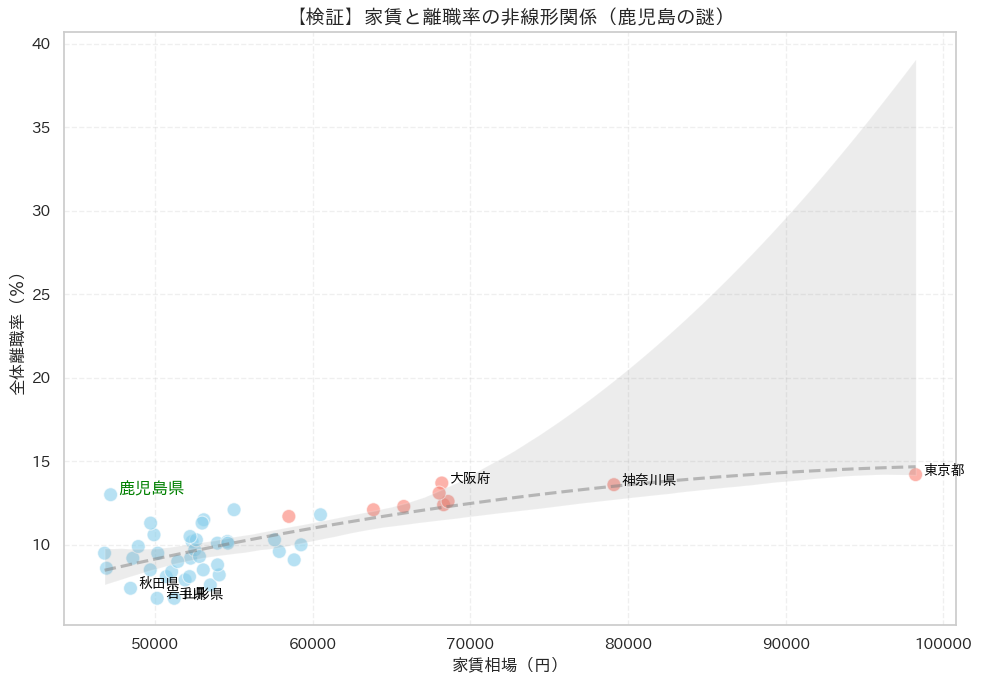

【鹿児島県の主要指標（全国偏差値のイメージ）】


,turnover_total,rent_private,annual_income,hospital_per_100k,job_openings_ratio
45,13.0,47188,442.29,14.8,1.3



全国平均:
turnover_total           10.1
rent_private          55987.4
annual_income           499.3
hospital_per_100k         8.0
job_openings_ratio        1.4
dtype: float64


In [26]:
# ---------------------------------------------------------
# 3-15. 家賃 vs 離職率の散布図（閾値と外れ値の検証）
# ---------------------------------------------------------

# グラフを描画するキャンバスのサイズを 横10インチ、縦7インチ に設定（少し大きめに見やすく）
plt.figure(figsize=(10, 7))

# 1. 基本の散布図（全県）の描画
# seabornの散布図作成関数を使用
sns.scatterplot(
    data=df,                             # 使用するデータフレームを指定
    x='rent_private',                    # 横軸（X軸）に「家賃」を設定
    y='turnover_total',                  # 縦軸（Y軸）に「全体離職率」を設定
    hue='metro_b',                       # 都市区分（0:地方, 1:大都市）で色分けする設定
    palette={0: 'skyblue', 1: 'salmon'}, # 0(地方)を空色、1(大都市)をサーモンピンクに指定
    s=100,                               # 点（マーカー）のサイズを100に設定（少し大きめで目立たせる）
    alpha=0.6,                           # 点の透明度を0.6に設定（重なっても透けて見えるように）
    legend=False                         # 凡例（色の説明）は邪魔になるので非表示にする
)

# 2. 注目エリアの強調（テキスト表示）
# 名前を表示したい都道府県のリストを作成（鹿児島、大都市ワースト、地方ベストなど）
targets = ['鹿児島県', '東京都', '大阪府', '神奈川県', '山形県', '岩手県', '秋田県']

# データフレームの全行を1行ずつループ処理（i=インデックス, row=その行のデータ）
for i, row in df.iterrows():
    # もし、その行の「都道府県名」がリスト(targets)の中にあったら処理を実行
    if row['prefecture'] in targets:
        
        # 色の設定：鹿児島県なら「緑」、それ以外は「黒」にする
        color = 'green' if row['prefecture'] == '鹿児島県' else 'black'
        
        # 太字の設定：すべての文字を太字にする
        weight = 'bold'
        
        # サイズの設定：鹿児島県なら「12（大きく）」、それ以外は「10」にする
        size = 12 if row['prefecture'] == '鹿児島県' else 10
        
        # グラフ上に文字（テキスト）を配置する
        plt.text(
            row['rent_private'] + 500, # X座標：点の位置より500円分右にずらして文字が重ならないようにする
            row['turnover_total'],     # Y座標：離職率の高さに合わせて配置
            row['prefecture'],         # 表示する文字（県名）
            fontsize=size,             # 文字サイズを適用
            color=color,               # 文字色を適用
            fontweight=weight          # 文字の太さを適用
        )

# 3. 傾向線（閾値が見えるか？）の描画
# データの傾向を表す回帰直線（曲線）を描く
sns.regplot(
    data=df,
    x='rent_private',                  # 横軸は同じく家賃
    y='turnover_total',                # 縦軸は同じく離職率
    scatter=False,                     # 点はすでに描いたので、ここでは線だけを描く（False）
    order=2,                           # 2次関数（放物線）で近似する（Jカーブを想定しているため）
    color='gray',                      # 線の色をグレーにして目立ちすぎないようにする
    line_kws={'linestyle': '--', 'alpha': 0.5}, # 線のスタイル設定（破線にし、透明度を上げて薄くする）
    label='全体の傾向（トレンドライン）'  # 凡例用のラベルを設定（※今回は表示していないが設定は可能）
)

# タイトルと軸ラベルの設定
plt.title('【検証】家賃と離職率の非線形関係（鹿児島の謎）', fontsize=14) # グラフ全体のタイトル
plt.xlabel('家賃相場（円）', fontsize=12)      # 横軸のラベル
plt.ylabel('全体離職率（％）', fontsize=12)    # 縦軸のラベル

# グリッド線（目盛りの線）を表示（linestyle='--'で破線、alpha=0.3で薄く）
plt.grid(True, linestyle='--', alpha=0.3)

# グラフのレイアウトを自動調整して、文字切れなどを防ぐ
plt.tight_layout()

# ここまで設定したグラフを画面に表示する
plt.show()

# 4. 鹿児島 vs 全国平均の数値比較
# データフレームから「鹿児島県」の行だけを抜き出す
kago = df[df['prefecture'] == '鹿児島県']

print("【鹿児島県の主要指標（全国偏差値のイメージ）】")

# 比較したい重要なカラム（離職率、家賃、年収、病院数、求人倍率）をリスト化
cols_check = ['turnover_total', 'rent_private', 'annual_income', 'hospital_per_100k', 'job_openings_ratio']

# 鹿児島県のデータを表示（Jupyter上で見やすく表示）
display(kago[cols_check])

# 全国の平均値を計算し、小数点第1位で丸めて表示
print(f"\n全国平均:\n{df[cols_check].mean().round(1)}")

### 考察：家賃水準と離職率の非線形性および地域特性に関する仮説

本分析で得られた「家賃相場」と「全体離職率」の散布図に基づき、看護師の離職行動に影響を与える環境要因について、以下の通り考察を行う。

#### **1. 家賃負担における「閾値」の存在と都市部の構造的要因**
散布図全体のトレンド（回帰曲線）を概観すると、家賃相場と離職率は単純な比例関係ではなく、特定の水準を超えると急激に上昇する非線形な関係（Jカーブ）を描いている可能性が示唆される。

* **閾値（スレッショルド）の仮定**:
    データからは、家賃相場が **50,000円〜60,000円** の範囲までは離職率が比較的低位で安定している傾向が見て取れる。しかし、このライン（閾値）を超え、60,000円台後半（東京都、神奈川県、大阪府など）に達すると、離職率は上昇傾向を強めている。
* **可処分所得圧迫の推定**:
    この現象は、都市部における給与水準の上昇分が、高騰する家賃コストによって相殺、あるいはそれ以上に圧迫されている可能性を示唆している。
    すなわち、額面の給与が高くとも、実質的な可処分所得や生活のゆとり（QOL）が確保できていない場合、経済的な不満が離職への「プッシュ要因」として強く機能していると推測される。

#### **2. 鹿児島県における「外れ値」の解釈と競合環境の影響**
一方で、鹿児島県は家賃相場が40,000円台と全国的に安価な水準にありながら、離職率は大都市圏と同等の高水準（約13%）を示しており、上述の「家賃要因」では説明がつかない特異な挙動（外れ値）を示している。この乖離については、以下の別要因が支配的であると推定される。

* **医療機関の過密と雇用の流動性**:
    鹿児島県は人口10万人あたりの病院数が全国平均を大きく上回る傾向にある。
    この「競合過多」の環境下では、看護師にとっての就業選択肢が豊富であるため、転職に対する心理的・物理的なハードルが他県に比べて著しく低いと仮定できる。
* **流動性リスクの顕在化**:
    生活コストによる圧迫がなくとも、「隣の病院へ容易に移れる」という環境そのものが、組織への帰属意識を希薄化させ、わずかな不満でも離職を選択させやすくしている可能性が高い。すなわち、ここでは「経済的苦境」ではなく「労働市場の流動性の高さ」が離職率を押し上げていると考えられる。

#### **3. 結論と施策への示唆**
以上の考察より、看護師の離職要因は一律ではなく、地域特性によって支配的なメカニズムが異なると考えられる。

* **大都市圏（高家賃エリア）に対して**:
    家賃が離職のドライバーとなっている可能性が高いため、離職率低減には「住宅手当の拡充」や「寮制度の整備」等、可処分所得を直接的に補填する施策が、閾値を下回らせるための有効な介入になると期待される。
* **高密度地方（鹿児島モデル）に対して**:
    経済的支援だけでは、高い流動性を抑制できない恐れがある。ここでは、他院との差別化を図るための「組織風土の改革」や「キャリア支援」など、"選び続けられる理由"を作るためのリテンション施策がより重要になると推測される。